# Signal Processing and Machine Learning for Finance Coursework



# ATTENTION: the text in this notebook is not the final text as in the report. The report has the official text.

## 1 Regression Methods


###  1.1 Processing stock price data in Python


####  1.1.1 Import


In [1]:
import numpy as np
import pandas as pd
from scipy import stats
from scipy.stats import pearsonr
from scipy.stats import norm
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter
from statsmodels.tsa.arima_model import ARIMA 
from statsmodels.tsa.ar_model import AR 
from statsmodels.robust.scale import mad
import copy
import warnings
from sklearn import linear_model
from sklearn.metrics import mean_squared_error
import seaborn as sn
from statsmodels.tsa.api import VAR
warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
px = pd.read_csv("priceData.csv", index_col="date")

#dropping nan values
px = px.dropna()

In [3]:
print(px)
print(type(px))

            SPX Index
date                 
02/01/1930      21.18
03/01/1930      21.23
06/01/1930      21.50
07/01/1930      21.31
08/01/1930      21.29
...               ...
15/06/2017    2432.46
16/06/2017    2433.15
19/06/2017    2453.46
20/06/2017    2437.03
21/06/2017    2434.36

[21974 rows x 1 columns]
<class 'pandas.core.frame.DataFrame'>


In [4]:
# transform dataframe to series (important for plotting)
px = px["SPX Index"]
# only transform the index to log
logpx = np.log(px)

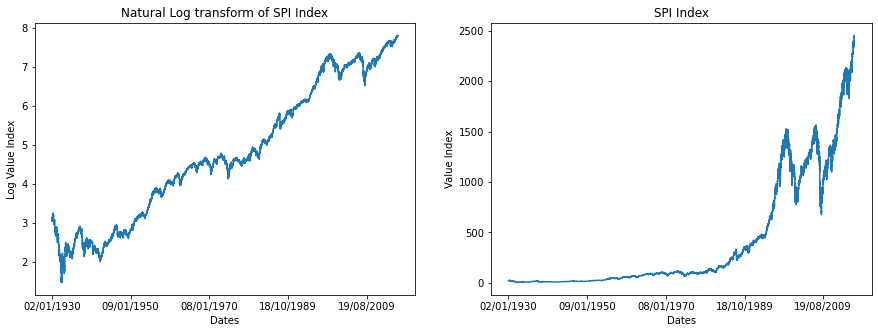

In [5]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
logpx.plot()
plt.title('Natural Log transform of SPI Index')
plt.xlabel('Dates')
plt.ylabel('Log Value Index')

plt.subplot(1,2,2)
px.plot()
plt.title('SPI Index')
plt.xlabel('Dates')
plt.ylabel('Value Index')

plt.show()

#### 1.1.2 Sliding Window

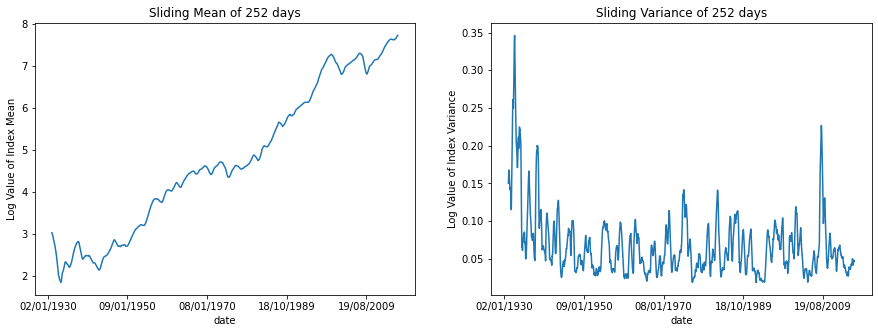

In [6]:
# sliding mean
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.title('Sliding Mean of 252 days')
plt.xlabel('Dates')
plt.ylabel('Log Value of Index Mean')
logpx.rolling(252).mean().plot()

# sliding standard deviation
plt.subplot(1,2,2)
plt.title('Sliding Variance of 252 days')
plt.xlabel('Dates')
plt.ylabel('Log Value of Index Variance')
logpx.rolling(252).std().plot()
plt.show()

#### 1.1.3 Log Return & Simple Return

In [7]:
# log return, diff(): out[i] = arr[i+1] – arr[i]
logret = logpx.diff()
# simple return, pct_change(): Percentage change between the current and a prior element.
simpret = px.pct_change()

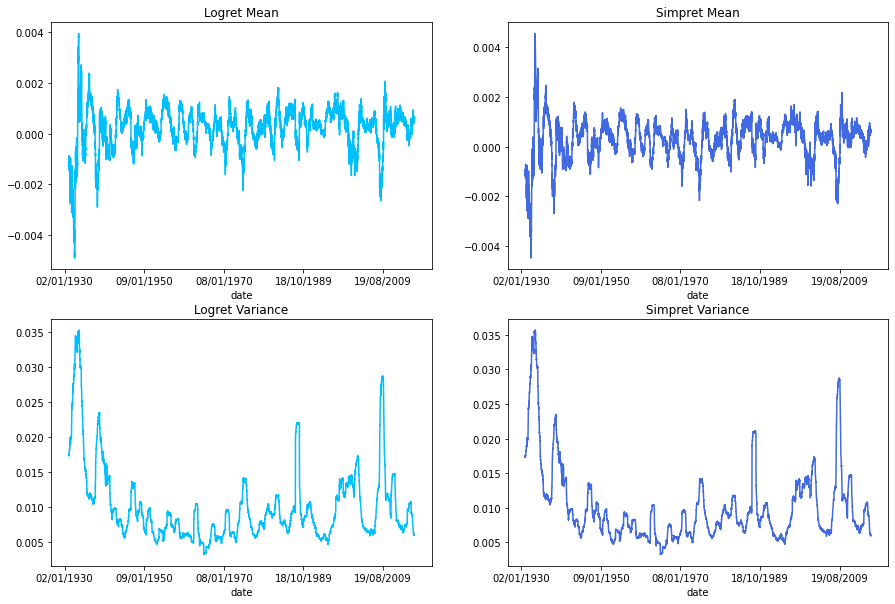

In [8]:
# sliding mean
plt.figure(figsize=(15,10))
plt.subplot(2,2,1)
plt.title('Logret Mean')
logret.rolling(252).mean().plot(color='deepskyblue')

plt.subplot(2,2,2)
plt.title('Simpret Mean')
simpret.rolling(252).mean().plot(color='royalblue')

plt.subplot(2,2,3)
plt.title('Logret Variance')
logret.rolling(252).std().plot(color='deepskyblue')

plt.subplot(2,2,4)
plt.title('Simpret Variance')
simpret.rolling(252).std().plot(color='royalblue')

plt.show()

The graphs we see for the sliding windows of the logret and simpret are much more stationary than the first plot we did in 1.1.1 . Therefore we can conclude that the log and simple price return time series is of order one.

#### 1.1.4 

Returns are defined as:     $$r[t] = \frac{p[t]}{p[t-1]}-1$$
Log-Returns are defined as: $$r[t] = ln(p[t])-ln(p[t-1]) =\log\frac{p[t]}{p[t-1]}$$

As seen in Lecture 2: Log-normality of prices: Over short periods of time, prices tend to be distributed log-normally (1). As a result:
    $$p[t] \sim \text{log-normal} $$
    $$\frac{p[t]}{p[t-1]} \sim \text{log-normal}$$
    $$r[t] = \log[\frac{p[t]}{p[t-1]}] \sim \text{normal}$$
    r[t] is hence considered to be conveniently normally distributed which is handy since many SP techniques assume normality.

Log return is concentrated around zero, which is convenient.
In addition, log compresses the range of data and also conditions the original data.
One great effeckt is that we can simply multiply and divide by log values and come back to the original value as compared to non log multiplication followed by division. E.g. for log returns, a 15 % increase in price followed by 15 % decrease results in the initial price, thus reflecting the symmetric behaviour of log returns.




With the help of statsmodels.jarque_bera() method, we can get the jarque bera test for normality and it’s a test based on skewness, and the kurtosis, and has an asymptotic distribution.
https://www.statology.org/jarque-bera-test-python/

Since the value is bellow 0.5, we reject the null hypothesis. Thus, we have sufficient evidence to say that this data has skewness and kurtosis that is significantly different from a normal distribution. This does not correspond to our thoughts above about the log return having a normal distribution. If we look at the data we can make the educated guess that this is because of the long timeframe of the data and the big amounts of datapoints. 


We see that we get a value over 0.5 and thus don't reject the null hypothesis and have sufficient evidence to say that this distribution has skewness and kurtosis of a normal distribution.
We also see a difference between the log transformed data and the plain data. We see that the log data are distributed much more like a normal distribution as the plain data.

In [9]:
steps = [i for i in range (21, len(logret.dropna()), 21)]
months = list(map(lambda x: int(x/21),steps))
logdiff_jb_vals = [stats.jarque_bera(logret.dropna()[:step]) for step in steps]
simpret_jb_vals = [stats.jarque_bera(simpret.dropna()[:step]) for step in steps]
log_jbs, log_pvals = map(list, zip(*logdiff_jb_vals))
simpret_jbs, simpret_pvals = map(list, zip(*simpret_jb_vals))

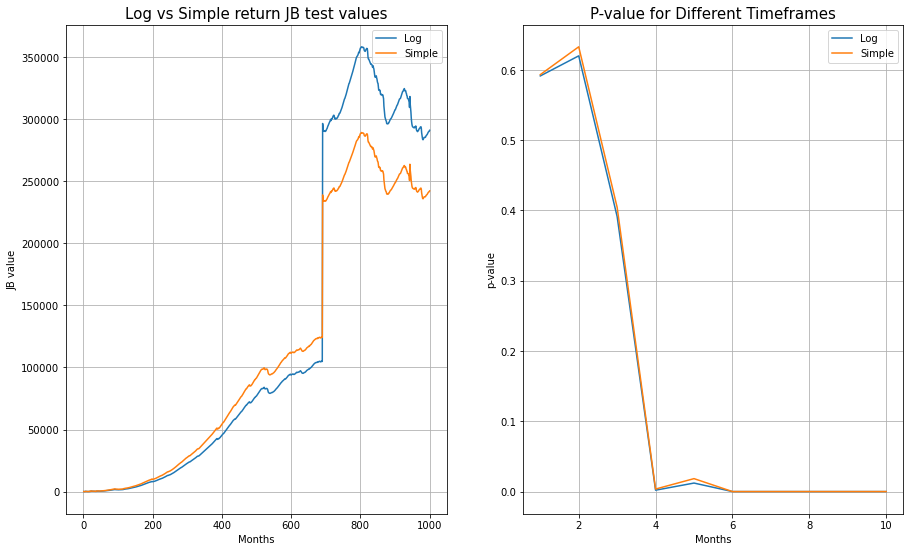

In [10]:
plotted_points = 1000
fig, (ax1, ax2) = plt.subplots(1,2, figsize = (15, 9))
ax1.set_title("Log vs Simple return JB test values", fontsize="15")
ax1.grid()
ax1.plot(months[:plotted_points], log_jbs[:plotted_points], label="Log")
ax1.plot(months[:plotted_points], simpret_jbs[:plotted_points], label="Simple")
ax1.set_xlabel('Months')
ax1.set_ylabel('JB value')
ax1.legend()

ax2.set_title("P-value for Different Timeframes", fontsize="15")
ax2.plot(months[:10], log_pvals[:10], label="Log")
ax2.plot(months[:10], simpret_pvals[:10], label="Simple")
ax2.grid()
ax2.set_xlabel('Months')
ax2.set_ylabel('p-value')
ax2.legend()
plt.show()

#### 1.1.5 Stock purchase

We can write ouut the entire calculation and see that the advantage of the log, we see that we come back to the same price.

$$r[1] = \log[\frac{p[t+1]}{p[t]}] = \log[\frac{2}{1}] = 0.69 $$
$$r[2] = \log[\frac{p[t+2]}{p[t+1]}] = \log[\frac{1}{2}] = -0.69 $$

Where t is the starting time were the stock was 1£.

So if we have have a positive log return in the first day of 0.69 and the next day the stock falls down to it's original value and we get the negative log return of -0.69 these two values just cancel each other out and we're at the point where we started.

#### 1.1.6 When not to use log returns

* As already seen in 1.1.4 the assumption of log-normality over long time-scales is unrealistic. A positive skew is assumed in log-normal distributions, but most financial data is negatively skewed in long time-scales, owing to financial crashes

* Logarithmic returns are not linearly additive across assets (whereas simple returns are linearly additive)

## 1.2 ARMA vs. ARIMA Models for Financial Applications

In [11]:
snp = pd.read_csv("snp_500_2015_2019.csv")
snp.set_index(['Date'], inplace=True)
snp_close = snp['Close'].to_frame().apply(np.log)

In [12]:
snp_close_ts = snp_close['Close'] # transformation from dataframe to series

### 1.2.1 Arma or Arima?

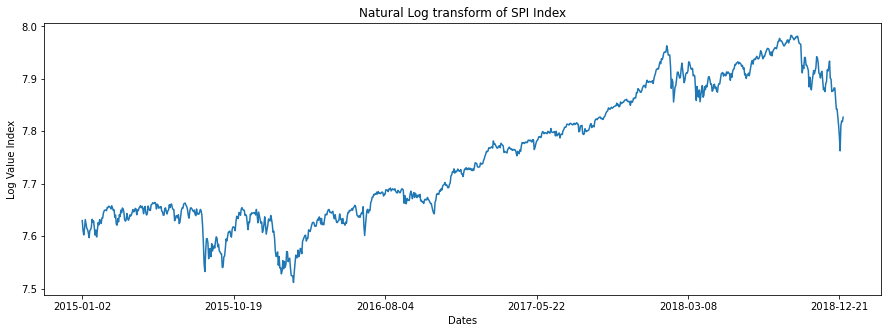

In [13]:
plt.figure(figsize=(15,5))
snp_close_ts.plot()
plt.title('Natural Log transform of SPI Index')
plt.xlabel('Dates')
plt.ylabel('Log Value Index')
plt.show()

ARMA models should be used when the data is stationary
In case the data shows elements of non-stationarity, a generalization of ARMA is used, i.e.
the autoregressive integrated moving average (ARIMA). We can see if the data is non stationary by looking at the sliding window mean and variance as seen above.

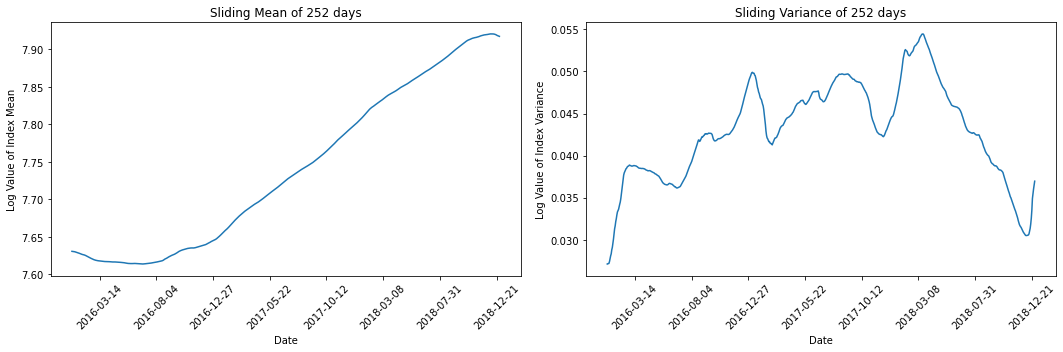

In [14]:
# sliding mean
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.title('Sliding Mean of 252 days')
plt.xlabel('Dates')
plt.ylabel('Log Value of Index Mean')
snp_close_ts.rolling(252).mean().plot()
plt.xticks(rotation=45)

# sliding standard deviation
plt.subplot(1,2,2)
plt.title('Sliding Variance of 252 days')
plt.xlabel('Dates')
plt.ylabel('Log Value of Index Variance')
snp_close_ts.rolling(252).std().plot()
plt.tight_layout()
plt.xticks(rotation=45)
plt.show()

We see the mean is not stationary and we therefore better use an ARIMA model.

### 1.2.2 Fit Arma model

In [15]:
snp_arma = copy.deepcopy(snp_close)
snp_arma.columns = ['True']
modelarma = ARIMA(snp_arma ,order = (1,0,0)).fit()
snp_arma['Res'] = modelarma.resid
snp_arma_rmse = np.sqrt(np.mean(snp_arma['Res']**2))
snp_arma['Prediction'] = snp_arma['True'] - snp_arma['Res']

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f= -3.33214D+00    |proj g|=  1.36670D-02

At iterate    5    f= -3.33271D+00    |proj g|=  2.09610D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      9     12      1     0     0   0.000D+00  -3.333D+00
  F =  -3.3327062307749138     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


 This problem is unconstrained.


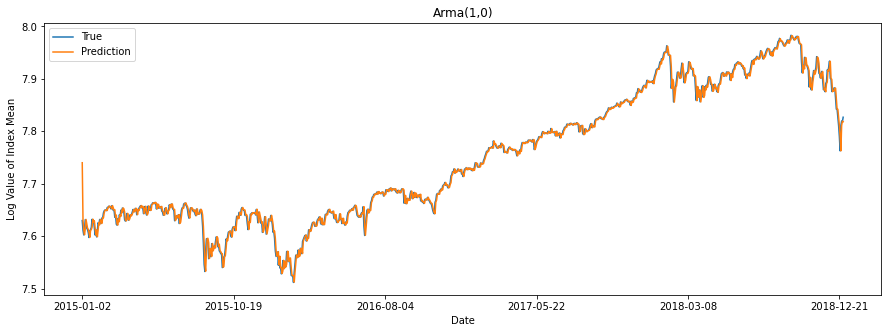

In [16]:
plt.figure(figsize=(15,5))
plt.title('Arma(1,0)')
plt.xlabel('Dates')
plt.ylabel('Log Value of Index Mean')
snp_arma["True"].plot()
snp_arma["Prediction"].plot()
plt.legend(["True","Prediction"])
plt.show()

In [17]:
display(modelarma.params)

const         7.739997
ar.L1.True    0.997359
dtype: float64

In [18]:
snp_arma = copy.deepcopy(snp_close)
snp_arma.columns = ['True']
modelarma5 = ARIMA(snp_arma ,order = (4,0,0)).fit()

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f= -3.33332D+00    |proj g|=  1.59244D-02

At iterate    5    f= -3.33406D+00    |proj g|=  3.01670D-04

At iterate   10    f= -3.33407D+00    |proj g|=  2.22045D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     13     18      1     0     0   8.882D-08  -3.334D+00
  F =  -3.3340652406598812     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


 This problem is unconstrained.


In [19]:
modelarma5.params

const         7.739234
ar.L1.True    0.990555
ar.L2.True   -0.043167
ar.L3.True    0.062720
ar.L4.True   -0.012640
dtype: float64

We see that the L1 coefficient is really near to 1 and therefore the next few coefficients would just be really small. Therefore also the optimal model order is 1. In practice we want to be able to predict the price of the index for future values, since the L1 just takes into consideration the last seen value, it is very bad at predicting the future value of the index, so there's no practical value in this model.

### 1.2.3 Arima (1,1,0)

In [20]:
snp_arima = copy.deepcopy(snp_close)
snp_arima.columns = ['True']
modelarima = ARIMA(snp_arima ,order = (1,1,0)).fit()
snp_arima['Res'] = modelarima.resid
snp_arima['Prediction'] = snp_arima['True'] - snp_arima['Res']

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f= -3.33487D+00    |proj g|=  2.49955D-01

At iterate    5    f= -3.33488D+00    |proj g|=  2.26485D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      6     16      1     0     0   8.882D-08  -3.335D+00
  F =  -3.3348750935177054     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


 This problem is unconstrained.


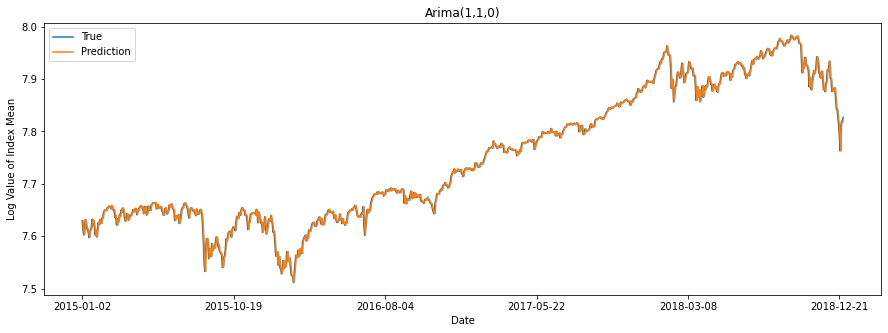

In [21]:
plt.figure(figsize=(15,5))
plt.title('Arima(1,1,0)')
plt.xlabel('Dates')
plt.ylabel('Log Value of Index Mean')
snp_arima["True"].plot()
snp_arima["Prediction"].plot()
plt.legend(["True","Prediction"])
plt.show()

We can again look at the RMSE by looking at the residues 

In [22]:
snp_arima_rmse = np.sqrt(np.mean(snp_arima['Res']**2))
print("Arma RMSE: ",snp_arma_rmse, "Arima RMSE: ", snp_arima_rmse)
print("Difference: ", snp_arma_rmse-snp_arima_rmse)

Arma RMSE:  0.009288260126805767 Arima RMSE:  0.008618764909411391
Difference:  0.0006694952173943759


Both models fit the data pretty good. We see that the Arima(1,1,0) does a slightly better approximation. Now if we try different arima models with different degrees, we can get some more insights.

In [23]:
snp_arima_rmse_dict = {}
for i in range (0,20):
    snp_arima = copy.deepcopy(snp_close)
    snp_arima.columns = ['True']
    modelarima = ARIMA(snp_arima ,order = (i,1,0)).fit(disp=0)
    snp_arima['Res'] = modelarima.resid
    snp_arima_rmse = np.sqrt(np.mean(snp_arima['Res']**2))
    snp_arima['Prediction'] = snp_arima['True'] - snp_arima['Res']
    snp_arima_rmse_dict[i] = snp_arima_rmse

In [24]:
display(snp_arima_rmse_dict)

{0: 0.008619092241596888,
 1: 0.008618764909411391,
 2: 0.008607195181514937,
 3: 0.008606681441828943,
 4: 0.008587341369335724,
 5: 0.008586955708982822,
 6: 0.008585706715522372,
 7: 0.008584177169524882,
 8: 0.00856277616767019,
 9: 0.00856043096415993,
 10: 0.008559742429132981,
 11: 0.00855797107484998,
 12: 0.008557845678735168,
 13: 0.008557543949305598,
 14: 0.008528452449345155,
 15: 0.008516113090304991,
 16: 0.008513364416898626,
 17: 0.00850202143680456,
 18: 0.008493808007187513,
 19: 0.00848628035589335}

We see the error becomes smaller and smaller and we still get a significant difference between results since they are of order $\geq 10^{-4}$ . Therefore these models of higher order could have a physical meaning and be practical in reality since they don't just look at the datapoint before but more complex correlations. So Arima(1,1,0) is more physically meaningful if we go to higher orders than Arma(1,0).

### 1.2.4 Why do we take log of prices?

If we take the arima model, we introduce a differentiation term, which as seen in the lecture can be approximated by a difference of two subsequent terms. If we now take the log of these terms, we see that the difference of those will give us back the log return. As already mentioned, stock prices over a short period tend to be log-normally distributed what then makes the log returns behave stationary.

## 1.3 Vector Autoregressive (VAR) Models

### 1.3.1

We can set the matrices as seen in the lecture slides as:

\begin{equation}
    \textbf{Y} = 
    \begin{pmatrix}
        y_{1,T-1} & y_{1,T-2} & \cdots & y_{1,0} \\
        y_{2,T-1} & y_{2,T-2} & \cdots & y_{2,0} \\
        \vdots        &       \vdots  & \ddots &       \vdots \\
        y_{K,T-1} & y_{K,T-2} & \cdots & y_{K,0} \\ 
    \end{pmatrix} \in R^{K \times T}
\end{equation}

<br>

\begin{equation}
    \textbf{A_i} =
        \begin{pmatrix}
        c_{1}      &      a_{1,1}^{i} & a_{1,2}^{i} & \cdots & a_{1,K}^{i}\\
        c_{2}      &      a_{2,1}^{i} & a_{2,2}^{i} & \cdots & a_{2,K}^{i}\\
        \vdots     &      \vdots      & \vdots      & \ddots & \vdots     \\
        c_{K}      &      a_{K,1}^{i} & a_{K,2}^{i} & \cdots & a_{K,K}^{i}\\ 
    \end{pmatrix} \in R^{K \times K}
\end{equation}

<br>

\begin{equation}
    \textbf{B} = 
    \begin{pmatrix}
        \textbf{A_1} & \textbf{A_2} & \cdots & \textbf{A_P}
    \end{pmatrix} \in R^{K \times (KP + 1)}
\end{equation}

<br>

\begin{equation}
    \textbf{Z} = 
    \begin{pmatrix}
            1             &        1      & \cdots &     1     \\
        y_{1,t-1}^{1} & y_{1,t-2}^{1} & \cdots & y_{1,t-p}^{1} \\
        y_{2,t-1}^{1} & y_{2,t-2}^{1} & \cdots & y_{2,t-p}^{1} \\
        \vdots        &       \vdots  & \ddots &       \vdots \\
        y_{K,t-1}^{1} & y_{K,t-2}^{1} & \cdots & y_{K,t-p}^{1} \\
        y_{1,t-1}^{2} & y_{1,t-2}^{2} & \cdots & y_{1,t-p}^{2} \\
        \vdots        &       \vdots  & \ddots &       \vdots \\
        y_{K,t-1}^{p} & y_{K,t-2}^{p} & \cdots & y_{K,t-p}^{p} \\ 
    \end{pmatrix} \in R^{(KP + 1) \times T}
\end{equation}

<br>

\begin{equation}
    \textbf{U} = 
    \begin{pmatrix}
        e_{1,T-1} & e_{1,T-2} & \cdots & e_{1,0} \\
        e_{2,T-1} & e_{2,T-2} & \cdots & e_{2,0} \\
        \vdots    &   \vdots  & \ddots &   \vdots \\
        e_{K,T-1} & e_{K,T-2} & \cdots & e_{K,0} \\ 
    \end{pmatrix} \in R^{K \times T}
\end{equation}

With that we can get the wanted concise form.

### 1.3.2

We can derive this expression by a least squares estimation of $\mathbf{B}$. Since $\mathbf{B}_{opt}$ is the optimal value for $\mathbf{B}$ the error term $\mathbf{U}$ has therefore to be minimized in a least squares fasion.

Our aim therefore is to minimize:
$$\mathbf{U}^{T}\mathbf{U}$$

At first we need to rearange our equation to get $\mathbf{U} = \mathbf{Y} - \mathbf{B}\mathbf{Z}$ and therefore: 
$$\mathbf{U}^{T}\mathbf{U} = (\mathbf{Y} - \mathbf{B}\mathbf{Z})^{T}(\mathbf{Y}- \mathbf{B}\mathbf{Z})$$





Now we have to differentiate $\mathbf{U}^{T}\mathbf{U}$ by $\partial\mathbf{B}$ to get the minimum. 

$$\frac{\partial \mathbf{U}^{T} \mathbf{U}}{\partial \mathbf{B}} =  \frac{\partial \mathbf{U}^{T}\mathbf{U}}{\partial \mathbf{U}^{T}} \frac{\mathbf{U}^{T}}{\partial \mathbf{B}}$$


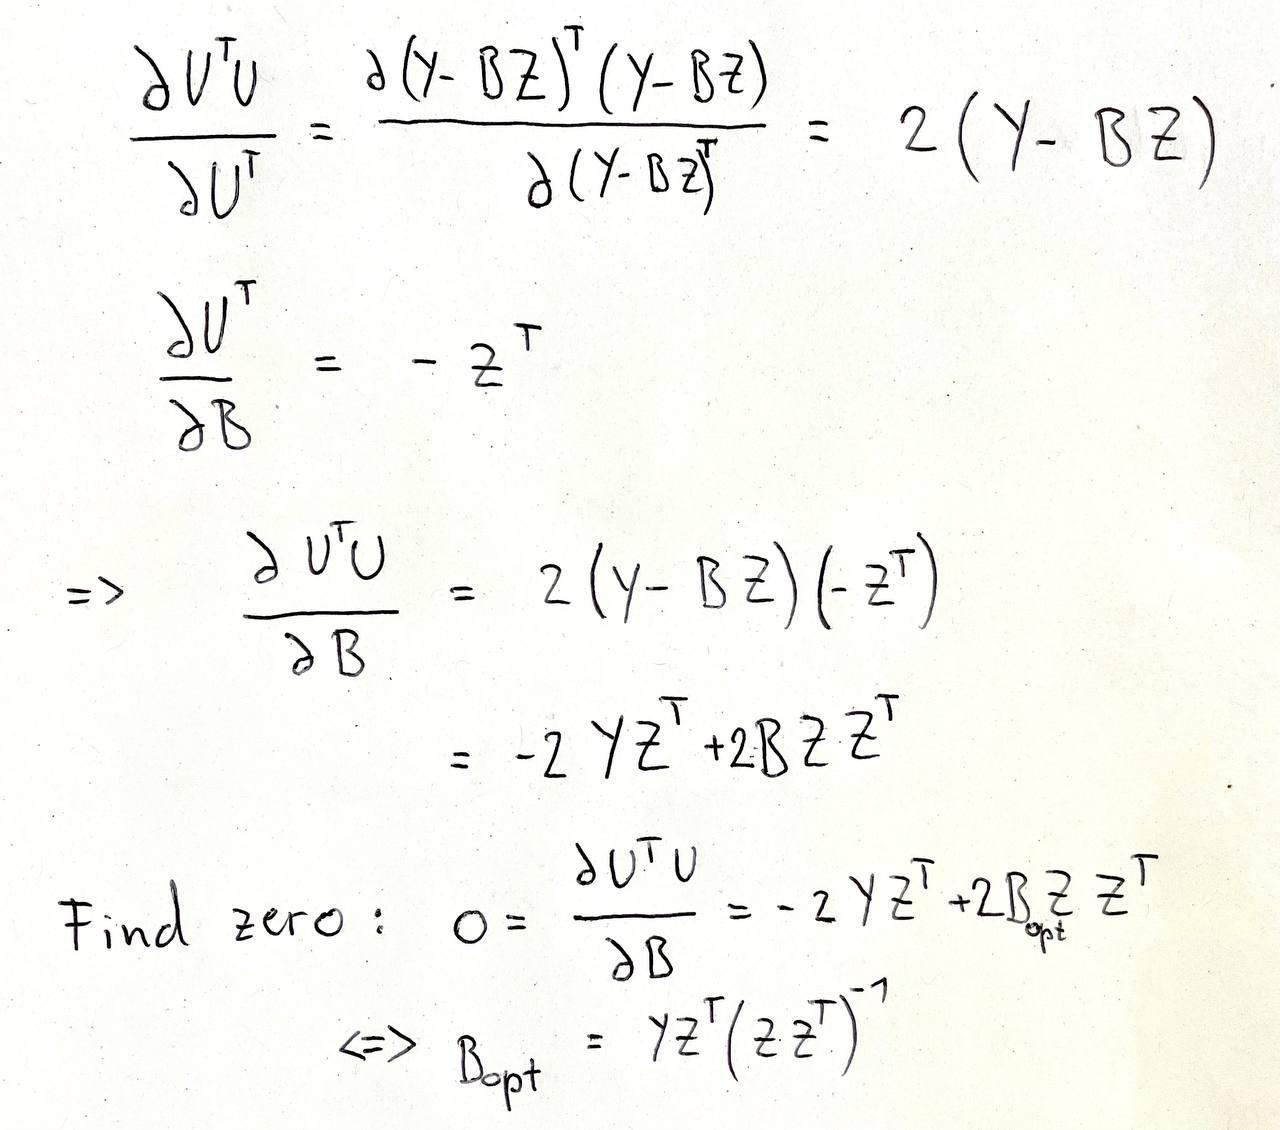

### 1.3.3

If we use equation 6 and insert it into 7 we see that we an inductively continue this to infinity. Therefore the effects of the eigenvalues of A have to be considered. Since we know that for a stable system the eigenvalues have to be less than 1 in absolute value for the system to be stable according to the Ralph-Hurwitz Criterion. To give a better idea one can imagine that we have a function with an exponent higher than the absolute value of 1 that describes a system, if we let this system run to infinity the terms will add up more and more and the system will be unstable, since the exponential terms won't die down.

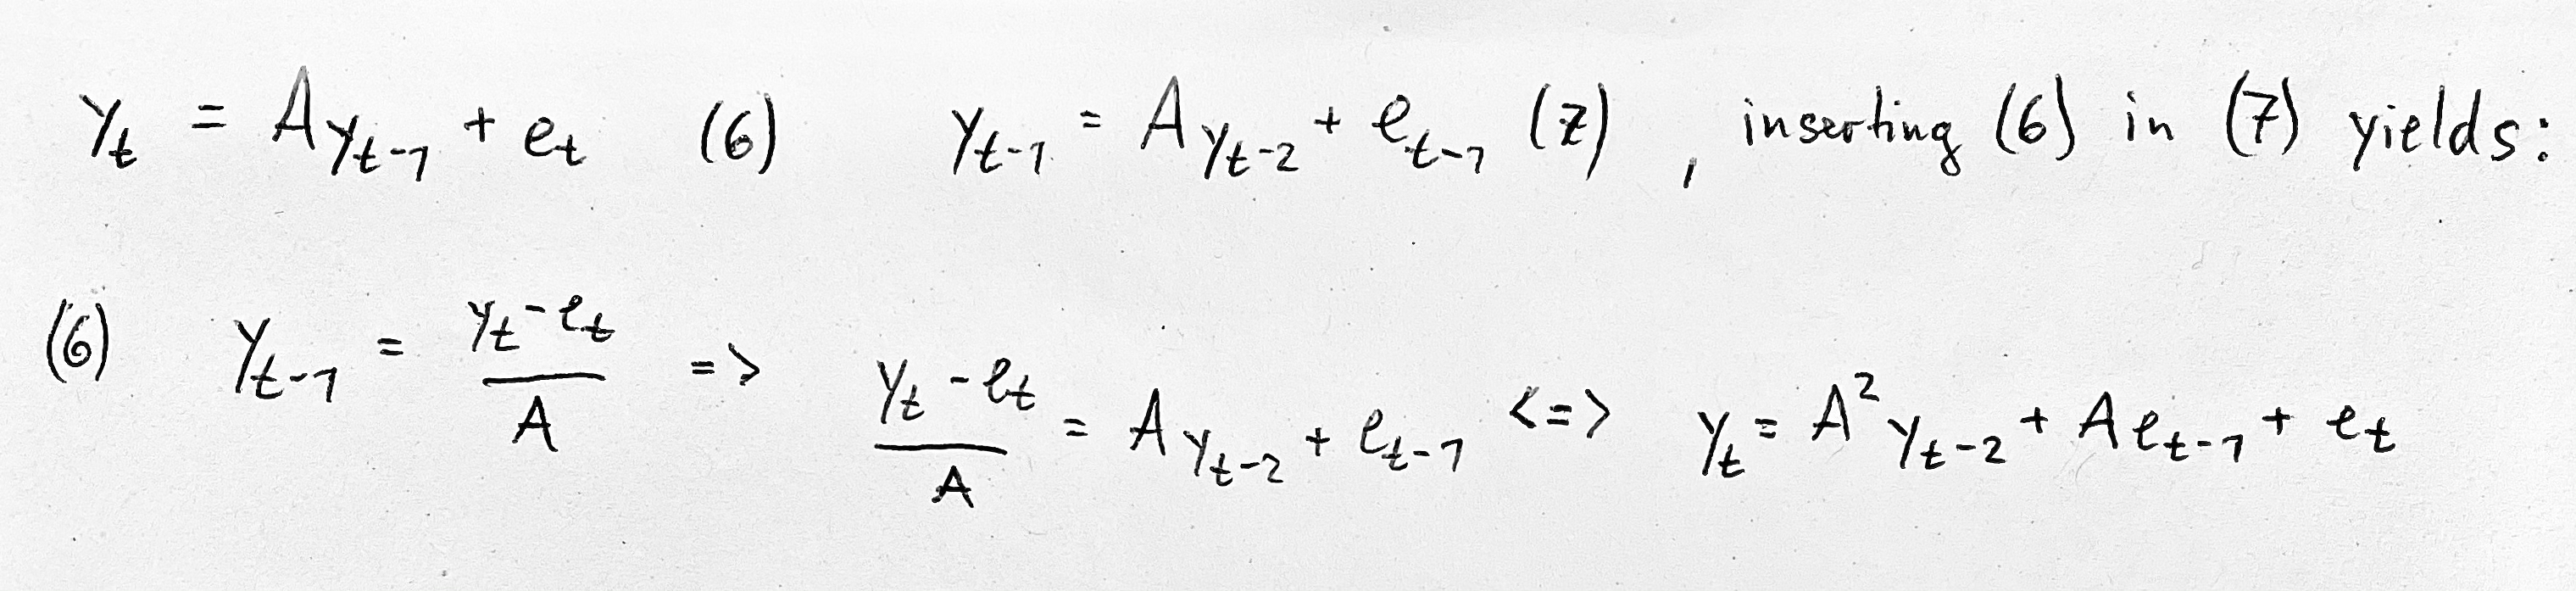

### 1.3.4

In [25]:
df = pd.read_csv(r'snp_allstocks_2015_2019.csv') 
df = df.set_index('Date')
info = pd.read_csv(r'snp_info.csv') 
info.drop(columns=info.columns[0], inplace=True)

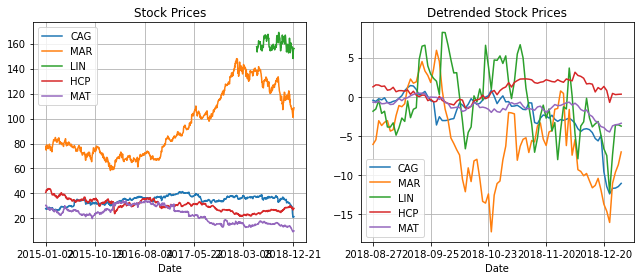

In [26]:
tickers = ['CAG','MAR','LIN','HCP','MAT']
stocks = df[tickers]
stocks_ma = stocks.rolling(window=66).mean()
stocks_detrended = stocks.sub(stocks_ma).dropna()

figure, axes = plt.subplots(nrows=1, ncols=2)
figure.set_size_inches(9,4)
figure.tight_layout()
stocks.plot(grid=True, title='Stock Prices', ax=axes[0])
stocks_detrended.plot(grid=True, title='Detrended Stock Prices', ax=axes[1])

figure.tight_layout()

In [27]:
model = VAR(stocks_detrended)
results = model.fit(1)
A = results.params[1:].values
eigA, _ = np.linalg.eig(A)

In [28]:
abs(eigA)

array([0.72609393, 0.72609393, 1.00635964, 0.86051894, 0.91144512])

Note that one of the eigenvalues has an absolute value of more than 1. Therefore this model is not stable and it's not a good idea to take up those stocks in the portfolio. We can also look at how correlated this values are, since we would prefer the values to be highly uncorrelated in a portfolio, since we want ot have the best diversification and therefore lowest risk.

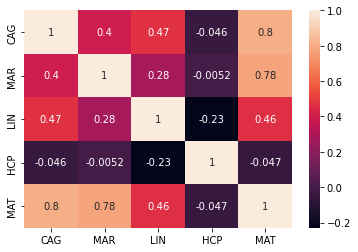

In [29]:
stocks_detrended.corr()
sn.heatmap(stocks_detrended.corr(), annot=True)
plt.show()

Looking at this correlation matrix, we see that some stocks are highly corrrelated and we should therefore not construct a portfolio with those values.

### 1.3.5

In [30]:
evals = pd.DataFrame(columns = info['GICS Sector'].unique(), 
                      index = ['min ev', 'max ev'])

for sector in info['GICS Sector'].unique():
    tickers = info.loc[info['GICS Sector']==sector]['Symbol'].tolist()
    stocks=df[tickers]
    stocks_ma = stocks.rolling(window=66).mean()
    stocks_detrended = stocks.sub(stocks_ma).dropna()
    model = VAR(stocks_detrended)
    results = model.fit(1)
    A = results.params[1:].values
    eigA, _ = np.linalg.eig(A)
    evals[sector]['min ev'] = np.min(abs(eigA))
    evals[sector]['max ev'] = np.max(abs(eigA))
    
    if (max(abs(eigA)<1)):
        print("Model is stable: ", sector)
    else:
        print("Model is not stable: ", sector)

Model is stable:  Industrials
Model is stable:  Health Care
Model is stable:  Information Technology
Model is stable:  Communication Services
Model is stable:  Consumer Discretionary
Model is stable:  Utilities
Model is stable:  Financials
Model is stable:  Materials
Model is stable:  Real Estate
Model is stable:  Consumer Staples
Model is stable:  Energy


In [31]:
display(evals.T)

min ev    max ev
Industrials             0.371246  0.991721
Health Care             0.092157  0.994153
Information Technology  0.374081  0.992738
Communication Services  0.752488  0.982263
Consumer Discretionary  0.447563   0.99065
Utilities               0.042115  0.985648
Financials              0.152575   1.00434
Materials               0.137838  0.991744
Real Estate             0.763563  0.982785
Consumer Staples        0.546458  0.991508
Energy                  0.825707  0.985577

We see that all the models that are fitted just onto the stocks of a certain sector show us a stable behavior. For portfolio construction it's not advisable to only take stocks from the same sector since they are highly positively correlated. Hence it is best if we take stocks from all the different sectors and look especially for negative correlations, since if the price of a stock A goes down and we have a stock B that is negatively correlated to stock A, stock B will probably behave contrarily and go up. Therefore we're pretty safe against losses, since some lossy stocks can get equalized with negatively correlated stocks to them. 
But one has to be careful, since the correlation between stocks is not a fixed factor, therefore it changes over time. As an example if there is a financial market crash like in 2007-2008 the correlation of many stocks goes up and a lot of stocks get highly correlated, since the entire market goes down.

## 2 Bond Pricing


### 2.1 Examples of Bond Pricing

#### 2.1.1

An investor has the following amounts of money at each timestep in years: year 0: USD1000, year 1: USD1100.

$V_{i}$ = initial value (USD1000), $V_{1}$ = final value after 1 year (USD1100)

Bellow are the different compounding periods. We use the formula 
$$ V_1 = V_i \times (1+\frac{R}{n})^{n}$$

and if we let n go to infinity we get

$$ lim_{n->\infty} (1+\frac{R}{n})^{n} = e^{R} $$

1. Annual:

$$ V_1= V_i \times (1+R) $$

$$ R={\frac {V_{1}-V_{i}}{V_{i}}} = 10\% $$


2. Semiannual: 

$$ V_1= V_i \times (1+\frac{R}{2})^2 $$
$$ R=(\sqrt{\frac{V_1}{V_i}}-1) \times 2 = 0.0976=9.76\%$$


3. Monthly:

$$ R = V_i \times (1+\frac{R}{12})^{12}$$
$$ R =[(\frac{V_1}{V_i})^{\frac{1}{12}}-1] \times 12 = 0.0956 = 9.56 \%  $$

4. Continuous:

$$ V_1 = V_i \times e^{R} $$
$$ R = \log_{e}(\frac{C_1}{V_i})=0.0953=9.53\% $$

#### 2.1.2

If we want to compare 15% of continuous compounding to monthly compounding on a per annum basis we have to set the two equations from above to be equal:

$$ V_i \times (1+\frac{R_m}{12})^{12} = V_i \times e^{R} $$


With $ R_m = 0.15 $ the per annum monthly compounding return rate.

We can then directly solve for R:
$$ R=\log_{e}((1+\frac{R_a}{12})^{12})=0.1491=14.91 \% $$


#### 2.1.3

Each time the interest is paid, we can add it to our account. We denote the amoun of interest paid with $I_i$ for $i = \{1,2,3,4\}$ and $X$ = USD10000 as the starting amount. 

- Q1: $ I_1 = X \times (e^{0.12 * 0.25} -1) = $ USD304.55
- Q2: $ I_2 = X + I_1 \times (e^{0.12 * 0.25} -1) = $ USD313.82
- Q3: $ I_3 = X + I_1 + I_2 \times (e^{0.12 * 0.25} -1) = $ USD323.23
- Q4: $ I_4 = X + I_1 + I_2 + I_3 \times (e^{0.12 * 0.25} -1) = $ USD333.23

Total: USD 1274.83


### 2.2 Forward rates

#### 2.2.1

a) It depends on the investor, if you don't want to spend this money to urgently, then you'll be happy with the 9% but if you need the money, you could also not be happy with 9%. The second year return rate is also higher than the second we want more return because we sacrifice the pleasure of spending the money for one more year.

b) In the arbitrage-free environment, the rates for different durations won't give an investor any advantages in the sense of arbitrage opportunities, since they are based on current market expectations. An investor will gain flexibility with going with a shorter duration of investment. Also in the real world, the risk of a default of the bank is not zero and therefore it is riskier to let your money with a certain bank for a longer amount of time.

c) Pros: With the 9% you earn more money then if you just invest each year for one year, therefore it is more profitable. You can also lock in the rate, which can be an advantage or disadvantage, depending on the market.

Cons: The investment is less flexible and riskier as mentioned above.

d) If we want to change from a 1 year investment to a 2 year investment before the start of the period there is nothing different needed. If we want to change during the year 1 then we would need to 

### 2.3 Duration of a coupon-bearing bond

#### 2.3.1

a) We can directly readd from the last row of the table:

$$ 0.0124 + 0.0236 + 0.0337 + 0.0428 + 0.0510 + 0.0583 + 6.5377 = 6.7595 $$

Therefore we get 6.76 years for the duration.

b) We get the modified duration, with annual yield to maturity of 5%, as:

$$ \text{Modified duration} = \text{Volatility}(\%)=  \frac{\text{Duration}}{1+\text{yield}} = \frac{6.7595}{1+0.05} = 6.4376 $$

We see the duration is shorter than above, because of the yield. The higher the yield the smaller the volatility.

c) The pension plan is usually a long term investment. Therefore we can make use of the long duration in order to stabilize the investment against unexpected changes of interest rates......
(?)



### 2.4 Capital Asset Pricing Model (CAPM) and Arbitrage Pricing Theory (APT)

#### 2.4.1 Average Return

In [32]:
import numpy as np
import pandas as pd


df = pd.read_csv(r'fsp_case_31_BSD.csv',index_col=0,header=[0,1])
df.index = pd.to_datetime(df.index)
df = df.sort_index()

# fill the nan values with a zero return for example at the 25.12 or 26.12
df_fill = df.fillna(0)
# drop nans for APT
df_drop = df.dropna(1)

In [33]:
# create a list of the daily average rerturns
daily_avg_returns = df_fill['ret'].copy().mean(axis=1)
daily_avg_returns_changed_index = daily_avg_returns.copy()
daily_avg_returns_changed_index.index = pd.to_datetime(daily_avg_returns_changed_index.index)

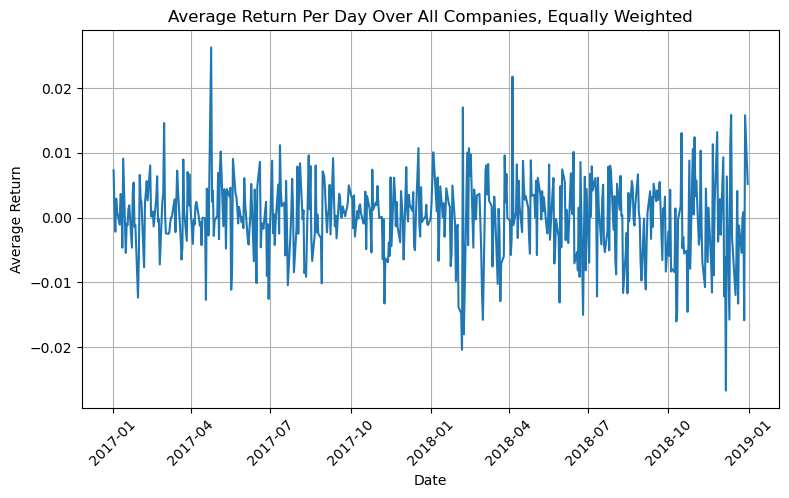

In [34]:
plt.figure(dpi=100, figsize=(9,5))
plt.plot(daily_avg_returns_changed_index)
plt.title('Average Return Per Day Over All Companies, Equally Weighted')
plt.xticks(rotation=45)
plt.xlabel('Date')
plt.ylabel('Average Return')
plt.grid()
plt.show()

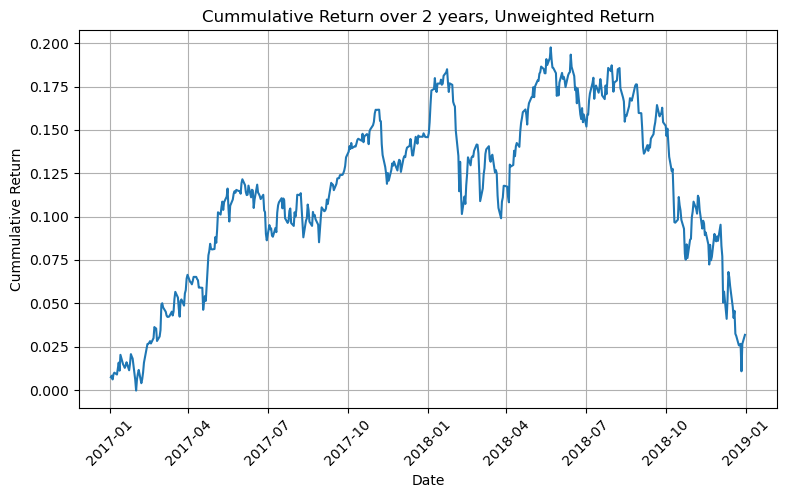

In [35]:
plt.figure(dpi=100, figsize=(9,5))
plt.plot(daily_avg_returns_changed_index.cumsum())
plt.xticks(rotation=45)
plt.title('Cummulative Return over 2 years, Unweighted Return')
plt.xlabel('Date')
plt.ylabel('Cummulative Return')
plt.grid()
plt.show()

#### 2.4.2 Rolling Beta

We recall the definition of the beta, the beta is the ratio between the covariance of an asset and the variance of the market. Therefore we get the following graphs, mean and standart deviation for the 22 day rolling Beta. 

In [36]:
cov_stocks = df_fill['ret'].rolling(22).cov(daily_avg_returns)
var_market = daily_avg_returns.rolling(22).var()
betas = pd.DataFrame(index=df_fill.index)
for company in cov_stocks:
    betas.loc[21:,company] = cov_stocks[company]/var_market
betas.drop(betas.index[0:21], inplace=True)

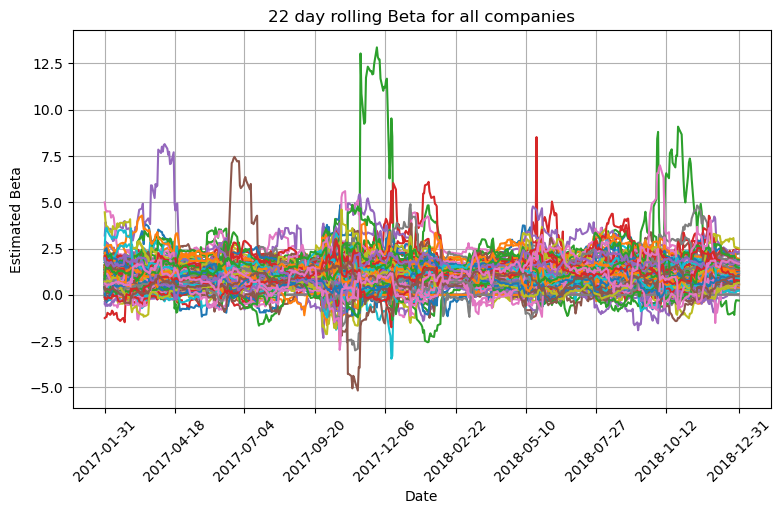

mean:  1.0000000000000004
std:   0.7742634277155881


In [37]:
plt.figure(dpi=100, figsize=(9,5))
plt.plot(betas.index, betas)
plt.xticks([betas.index[i] for i in np.linspace(0,len(betas.index)-1, 10).astype(int)],rotation=45)
plt.title('22 day rolling Beta for all companies')
plt.xlabel('Date')
plt.ylabel('Estimated Beta')
plt.grid()
plt.show()

print('mean: ', np.mean(betas.values.reshape(-1)))
print('std:  ', np.std(betas.values.reshape(-1)))

From the mean and the standart deviation we see that on average the stocks are perfectly correlated with the market (mean = 1), but also averaging through the stocks, they are about 76% more volatile than the market itself.

#### 2.4.3 Cap-weighted Market Return

We can interpret the weighting coefficient as giving a sense of the bigger picture of the market cap. Since we divide by the sum of all market caps we can therefore get a relative measure of each investment's market cap.
Therefore we get a value that is a fraction of the sum of all market cap for each investment. This is important since oftentimes in the real world one has not an evenly weighted portfolio.

In [38]:
marketcap_tot = df_fill['mcap'].copy().sum(axis=1)
marketcap_tot = np.array(marketcap_tot)
numerator = df_fill['ret']*df_fill['mcap']
asset_returns = numerator/marketcap_tot.reshape(-1,1)
market_returns = asset_returns.sum(axis=1)

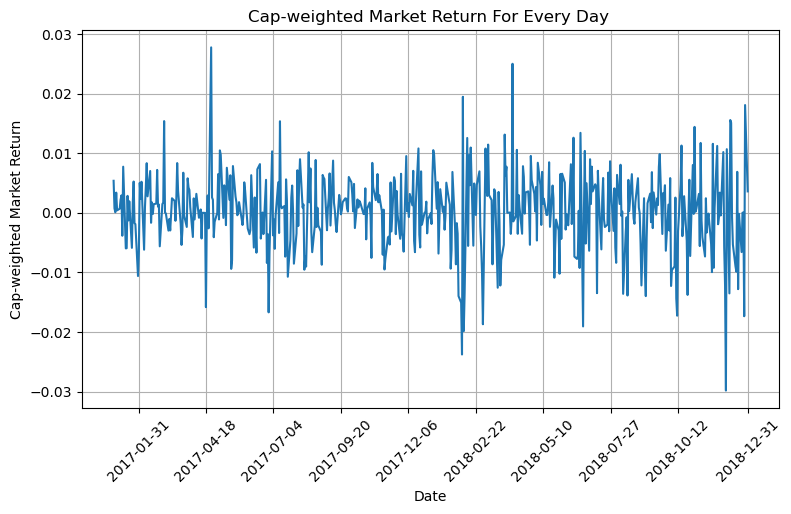

In [39]:
plt.figure(dpi=100, figsize=(9,5))
plt.plot(market_returns)
plt.xticks([betas.index[i] for i in np.linspace(0,len(betas.index)-1, 10).astype(int)],rotation=45)
plt.title('Cap-weighted Market Return For Every Day ')
plt.xlabel('Date')
plt.ylabel('Cap-weighted Market Return')
plt.grid()
plt.show()

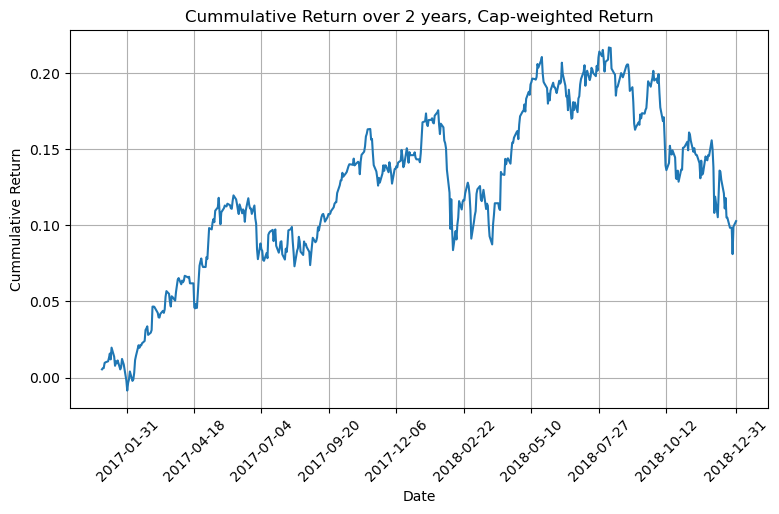

In [40]:
plt.figure(dpi=100, figsize=(9,5))
plt.plot(market_returns.cumsum())
plt.xticks([betas.index[i] for i in np.linspace(0,len(betas.index)-1, 10).astype(int)],rotation=45)
plt.title('Cummulative Return over 2 years, Cap-weighted Return')
plt.xlabel('Date')
plt.ylabel('Cummulative Return')
plt.grid()
plt.show()

If we compare the cummulative return to the unweighted return, we see much higher return. Therefore we see that bigger companies i.e. companies with a bigger fraction of the market tend to perform better than smaller ones. Which is completely logical, since if they perform well, investors will invest in them, giving them a bigger share in the market.

#### 2.4.4 Rolling Beta with Cap-weighted Market Returns

In [41]:
cov_stocks_mr = df_fill['ret'].rolling(22).cov(market_returns)
var_market_mr = market_returns.rolling(22).var()
betas_m = pd.DataFrame(index=df_fill.index)
for company in cov_stocks_mr:
    betas_m.loc[21:,company] = cov_stocks_mr[company]/var_market_mr
betas_m.drop(betas_m.index[0:21], inplace=True)

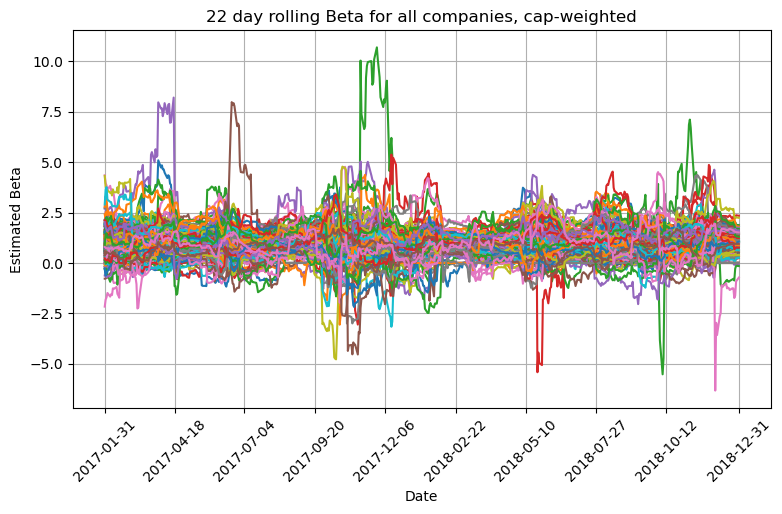

mean:  0.9066039347377957
std:   0.7162391915448689


In [42]:
plt.figure(dpi=100, figsize=(9,5))
plt.plot(betas_m.index, betas_m)
plt.xticks([betas_m.index[i] for i in np.linspace(0,len(betas_m.index)-1, 10).astype(int)],rotation=45)
plt.title('22 day rolling Beta for all companies, cap-weighted')
plt.xlabel('Date')
plt.ylabel('Estimated Beta')
plt.grid()
plt.show()

print('mean: ', np.mean(betas_m.values.reshape(-1)))
print('std:  ', np.std(betas_m.values.reshape(-1)))

We see that here is we get a smaller mean, which reflects the fact that the average stocks are not perfectly correlated to the market anymore as seen before. Also the standard deviation is smaller, so the volatility is smaller than for an unweighted portfolio. This makes sense, since the smaller, more volatile companies get weighted less with this technique.

### 2.4.5 Arbitrage Pricing Theory

In the APT we assume that the expected return of an asset is a linear combination of diverese factors. Here in this exercise we assume two such linear factors. 
The model is given by:

$$ r_j = a + b_{m_i}R_m + b_{s_i}R_s + \epsilon_j $$

If we put everything into a matrix form we get:


\begin{equation}
    \begin{pmatrix}
        r_{1} \\
        r_{2} \\
        \vdots \\
        r_{n} \\
    \end{pmatrix}
    =
    \begin{pmatrix}
        1 & b_{m,1} & b_{s,1} \\
        1 & b_{m,2} & b_{s,2} \\
        \vdots & \vdots & \vdots \\
        1 & b_{m,n} & b_{s,n}\\
    \end{pmatrix}
    \begin{pmatrix}
        a \\
        R_m \\
        R_s\\
    \end{pmatrix}
    +
    \begin{pmatrix}
        \epsilon_1 \\
        \epsilon_2 \\
        \vdots \\
        \epsilon_n \\
    \end{pmatrix}
\end{equation}

$$ \textbf{R = Ax + E} $$

Which we transform to:

$$ \textbf{x} = (\textbf{A}^T\textbf{A})^{-1}\textbf{A}^T\textbf{(R-E)} $$

We get the $(\textbf{A}^T\textbf{A})^{-1}\textbf{A}^T$ term, since we cannot directly invert $\textbf{A}$.

We can now calculate the $ a $, $ R_m $ and $ R_s $ by solving the linear system of equations. Since for the values in A we, as seen beofre, can consider the 22-day rolliin beta as sensitivity to the market returns and we also have that $b_{s_i} = ln(size)$.

a) Estimate $ a $, $ R_m $ and $ R_s $

In [43]:
# get the betas
cov_stocks_mr = df_drop['ret'].rolling(22).cov(market_returns)
var_market_mr = market_returns.rolling(22).var()
betas_m = pd.DataFrame(index=df_fill.index)
for company in cov_stocks_mr:
    betas_m.loc[21:,company] = cov_stocks_mr[company]/var_market_mr
betas_m.drop(betas_m.index[0:21], inplace=True)

In [44]:
index = df_drop.index.intersection(betas_m.index)
returns = df_drop["ret"].loc[index]

b_m = betas_m.copy()
b_m = b_m.loc[index]
b_s = np.log(df_drop['mcap'].loc[index])

R_m = pd.Series(index = returns.index, dtype='float64')
R_s = pd.Series(index = returns.index, dtype='float64')
a = pd.Series(index = returns.index, dtype='float64')
e = pd.DataFrame(index = returns.index, columns = returns.columns)

for i in returns.index:
    r_i = returns.loc[i].values.reshape(-1,1)
    b_m_i = b_m.loc[i].values.reshape(-1,1)
    b_s_i = b_s.loc[i].values.reshape(-1,1)
    ones_matrix = np.ones((r_i.shape))
    A = np.hstack((ones_matrix, b_m_i, b_s_i))

    x = np.linalg.inv(A.T.dot(A)).dot(A.T).dot(r_i)
    
    a[i] = float(x[0])
    R_m[i] = float(x[1])
    R_s[i] = float(x[2])
    e.loc[i] = (r_i-A.dot(x)).reshape(1,-1)


Now we have a a, R_m and a R_s for each day.

In [45]:
np.size(betas_m)

70500

b) To have a better look at the Magnitude and Variance of the parameters, we can plot them and their distribution.

Mean      S.D.
R_m -0.000288  0.007871
R_s  0.000193  0.001733
a   -0.004234  0.041209

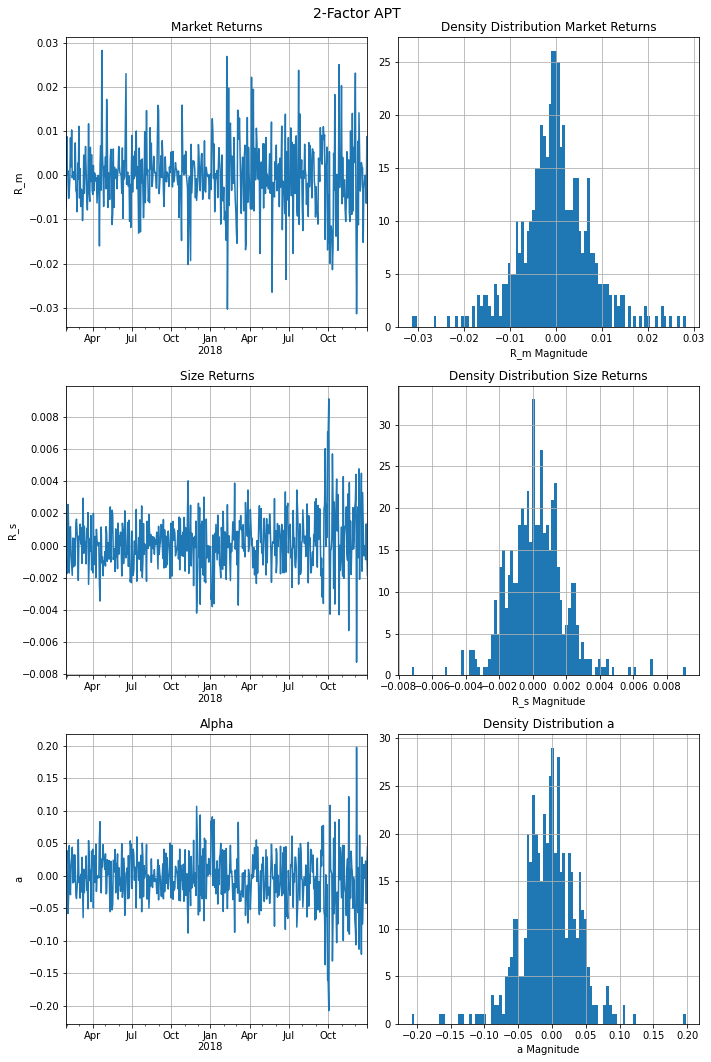

In [46]:
fig, (ax1, ax2, ax3) = plt.subplots(3,2, figsize = (10, 15))
fig.suptitle("2-Factor APT", fontsize=14)
R_m.plot(legend=False, ax=ax1[0], title='Market Returns', grid=True, ylabel='R_m')
R_s.plot(legend=False, ax=ax2[0], title='Size Returns', grid=True, ylabel='R_s')
a.plot(legend=False, ax=ax3[0], title='Alpha', grid=True, ylabel='a')

ax1[1].hist(R_m, 100)
ax1[1].set_title('Density Distribution Market Returns')
ax1[1].grid()
ax1[1].set_xlabel('R_m Magnitude')
ax2[1].hist(R_s, 100)
ax2[1].set_title('Density Distribution Size Returns')
ax2[1].grid()
ax2[1].set_xlabel('R_s Magnitude')
ax3[1].hist(a, 100)
ax3[1].set_title('Density Distribution a')
ax3[1].grid()
ax3[1].set_xlabel('a Magnitude')

fig.tight_layout()

ParamsStats = pd.DataFrame(index=['R_m','R_s','a'], columns=['Mean', 'S.D.'])
ParamsStats.loc['R_m'] =[R_m.mean(), R_m.std()]
ParamsStats.loc['R_s'] =[R_s.mean(), R_s.std()]
ParamsStats.loc['a'] =[a.mean(), a.std()]

ParamsStats

From the probability density histograms we see that we get some nice gaussian distributions. But none of the factors really shows us the market trend that we found before of going up.

c)

Mean    0.811413
S.D.    0.075935
dtype: float64

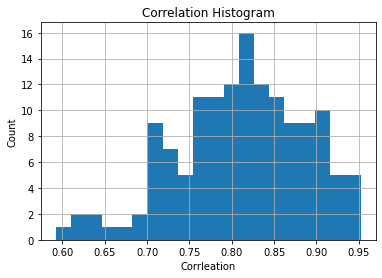

In [47]:
correlations = pd.Series(index=e.columns)

for company in e.columns:
    correlations[company] = pearsonr(e[company], returns[company])[0]

correlations.hist(bins=20)
plt.title("Correlation Histogram")
plt.xlabel("Corrleation")
plt.ylabel("Count")

pd.Series({'Mean': correlations.mean(), "S.D.": correlations.std()})

As the e is the specific return, we would expect it's mean to be near zero if the model would fit goodly to the returns over time. As we see this is not the case and therefore this ARP 2-factor model does not fully explain the return over time of the assets.

d) We can look at the rate of change in order to know about the stability of the model. Since we see the big red spikes at arbitrary times in our plot we can conclude as said before, that the two factor model is not enough to explain the returns. That's because the big spikes show a big change in relation of the two $R_m$ and $R_s$ and therefore they change unpredictable and really fast to each other.

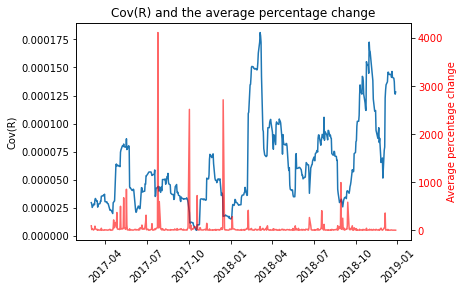

In [48]:
R = pd.DataFrame(columns=["R_m","R_s"])
R["R_m"] = R_m
R["R_s"] = R_s

R_mat = []

for i in R.index[21:]:
    R_T = R[:i][-22:].transpose()
    R_mat.append(np.cov(R_T))
    
R_mat = np.array(R_mat)

roll_mag = pd.Series(index = R.index[21:], dtype = 'float')
roll_stab = pd.Series(index = R.index[21:], dtype = 'float')

for i in range(R_mat.shape[0]-1):
    current_R = R_mat[i]
    roll_mag[i] = (np.linalg.norm(current_R))
    
    previous_R = R_mat[i-1]
    roll_stab[i] = (100 * np.mean(abs((current_R - previous_R)/ previous_R)))

fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.plot(roll_mag)
ax1.set_ylabel('Cov(R)')
plt.xticks(rotation=45)
plt.title('Cov(R) and the average percentage change')

ax2 = ax1.twinx()
ax2.plot(roll_stab, 'r-', alpha = 0.6)
ax2.set_ylabel('Average percentage change', color='r')
for tl in ax2.get_yticklabels():
    tl.set_color('r')

e) We take over e from 5a), calculate it's covariance matrix and calulcate the eigenvalues of the covariance matrix. This eigenvalues are then the principal components of the matrix $E$.

The explained variance of the first component is:  7.3543 %
The explained variance of the first and second component is:  12.3672 %
The explained variance of the first and second component is:  79.6691 %


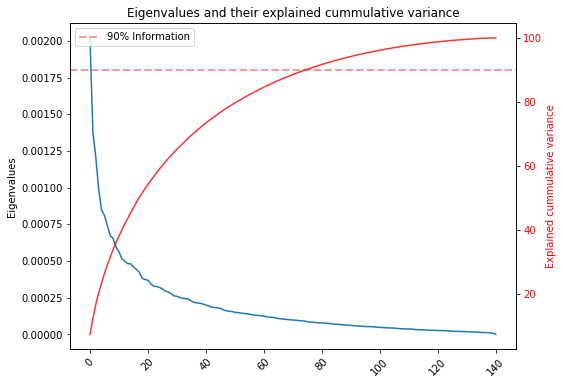

In [49]:
eigvalues,_ = np.linalg.eigh(e.astype(float).cov())
cum_var = np.cumsum(eigvalues[::-1]/sum(eigvalues)*100)

fig = plt.figure(figsize=(8,6))
ax1 = fig.add_subplot(111)
ax1.plot(eigvalues[::-1])
ax1.set_ylabel('Eigenvalues')
plt.xticks(rotation=45)
plt.title('Eigenvalues and their explained cummulative variance')

ax2 = ax1.twinx()
ax2.plot(cum_var, 'r-', alpha = 0.8)
ax2.set_ylabel('Explained cummulative variance', color='r')
ax2.axhline(y = 90, linestyle = '--', linewidth = 2, alpha = 0.4, color = 'r', label = '90% Information')
ax2.legend()
for tl in ax2.get_yticklabels():
    tl.set_color('r')
    
print('The explained variance of the first component is: ', round(cum_var[0],4), '%' )
print('The explained variance of the first and second component is: ', round(cum_var[1],4), '%' )
print('The explained variance of the first and second component is: ', round(cum_var[50],4), '%' )

We see that the first two principal components only explain a small percentage of the variance. This observation is in line with the observations from before, where we saw that the two factor model is to simple to explain the returns.

## 3 Portfolio Optimization

### 3.1 Adaptive minimum-variance portfolio optimization

#### 3.1.1

Our task is to find the optimal value for the weights such that the variance of the portfolio is minimal.


We can directly take the lagrangian that is proposed in the exercise:

$$ 
L = \frac{1}{2} \textbf{w}^T\textbf{C}\textbf{w} - \lambda (\textbf{w}^T \textbf{1} - 1) 
$$

Now we differentiate with respect to $\textbf{w}$ giving us $\textbf{w}_{opt}$ which stands for the optimal set of weights:

$$ 
\frac{\partial L}{ \partial \textbf{w}} = \textbf{C}\textbf{w}_{opt} - \lambda \textbf{1} 
$$

Setting the derivative to zero to obtain the optimum gives us:

$$
0 = \textbf{C}\textbf{w}_{opt} - \lambda \textbf{1} \Rightarrow \textbf{w}_{opt} = \lambda \textbf{C}^{-1} \textbf{1}
$$ 

Now differentiating with respect to $\lambda$, setting the derivative to 0 we get:

$$
\frac{\partial L}{ \partial \lambda} = \textbf{w}_{opt}^T \textbf{1} - 1 = 0 \Rightarrow \textbf{w}_{opt}^T \textbf{1} = 1 
$$

Now we can substitute the first equation into the second to get:

$$ 
\lambda \textbf{1}^T \textbf{C}^{-1} \textbf{1} = 1 
$$

Solving for $\lambda$

$$
\lambda = \frac{1}{\textbf{1}^T \textbf{C}^{-1} \textbf{1}}
$$

Substituting to equation third equation we get:

$$
\textbf{w}_{opt} = \frac{\textbf{C}^{-1} \textbf{1}}{\textbf{1}^T \textbf{C}^{-1} \textbf{1}}
$$

Now to get the variance of the optimal portfolio we can just plug in the value we found for $\textbf{w}_{opt}$

$$ 
\bar{\mu}_{opt} = \textbf{w}_{opt}^{T} \mu =  
        \frac{C^{-1} \textbf{1}}{\textbf{1}^T \textbf{C}^{-1} \textbf{1}} \mu
$$
        
$$
\bar{\sigma}^{2}_{opt} = \textbf{w}_{opt}^{T}\textbf{C}\textbf{w}_{opt} = 
    \frac{1}{\textbf{1}^T \textbf{C}^{-1} \textbf{1}} = \lambda
$$

#### 3.1.2

In [50]:
# basic data preprocessing
df = pd.read_csv('fsp_case_31_BSD.csv', index_col = 0, header = [0 ,1]) 
returns = df['ret'].copy().fillna(0) 
returns.index = pd.to_datetime(returns.index) 
returns = returns.iloc[:, -10:]

# split
train_returns = returns.iloc[:int(returns.shape[0]/2), :]
test_returns  = returns.iloc[int(returns.shape[0]/2):, :]

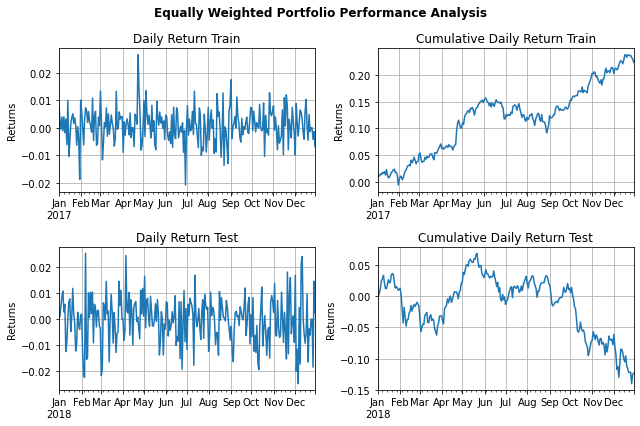

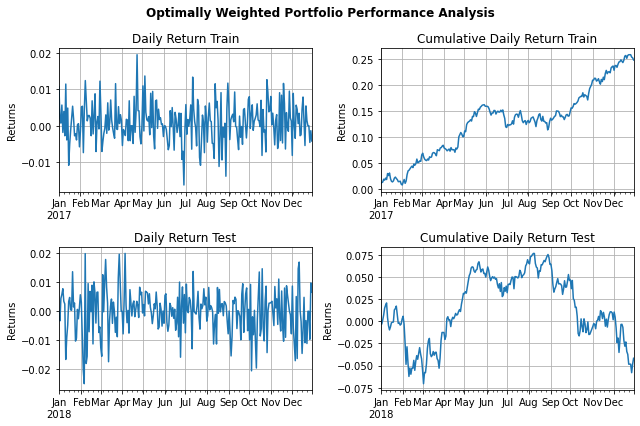

In [51]:
# since we have a equally weighted portfolio, we can just take the mean of the data to get the resulting portfolio returns

equally_weighted_portfolio_train = train_returns.mean(1)
equally_weighted_portfolio_test  = test_returns.mean(1)

fig, (ax1, ax2) = plt.subplots(2,2)
fig.suptitle(f'Equally Weighted Portfolio Performance Analysis', fontsize=12, fontweight="bold")
fig.set_size_inches(9,6)
equally_weighted_portfolio_train.plot(grid=True, title='Daily Return Train', ax=ax1[0]).set_ylabel('Returns')
equally_weighted_portfolio_train.cumsum().plot(grid=True, title='Cumulative Daily Return Train', ax=ax1[1]).set_ylabel('Returns')
plt.tight_layout()

fig.set_size_inches(9,6)
equally_weighted_portfolio_test.plot(grid=True, title='Daily Return Test', ax=ax2[0]).set_ylabel('Returns')
equally_weighted_portfolio_test.cumsum().plot(grid=True, title='Cumulative Daily Return Test', ax=ax2[1]).set_ylabel('Returns')
plt.tight_layout()

#optimal weights train

ones = np.ones(train_returns.shape[1])
C = train_returns.cov()
tvar_lambda_train = 1/(ones.T.dot(np.linalg.inv(C).T).dot(ones))
Lambda = 1/(ones.T.dot(np.linalg.inv(C).T).dot(ones))
w_opt = Lambda*(np.linalg.inv(C).dot(ones)).reshape(-1)

optimally_weighted_portfolio_train = (train_returns*w_opt).sum(1)

fig, (ax1, ax2) = plt.subplots(2,2)
fig.suptitle(f'Optimally Weighted Portfolio Performance Analysis', fontsize=12, fontweight="bold")
fig.set_size_inches(9,6)
optimally_weighted_portfolio_train.plot(grid=True, title='Daily Return Train', ax=ax1[0]).set_ylabel('Returns')
optimally_weighted_portfolio_train.cumsum().plot(grid=True, title='Cumulative Daily Return Train', ax=ax1[1]).set_ylabel('Returns')
plt.tight_layout()

#optimal weights test

ones = np.ones(test_returns.shape[1])
C = test_returns.cov()
tvar_lambda_test = 1/(ones.T.dot(np.linalg.inv(C).T).dot(ones))
Lambda = 1/(ones.T.dot(np.linalg.inv(C).T).dot(ones))
w_opt = Lambda*(np.linalg.inv(C).dot(ones)).reshape(-1)

optimally_weighted_portfolio_test = (test_returns*w_opt).sum(1)

fig.set_size_inches(9,6)
optimally_weighted_portfolio_test.plot(grid=True, title='Daily Return Test', ax=ax2[0]).set_ylabel('Returns')
optimally_weighted_portfolio_test.cumsum().plot(grid=True, title='Cumulative Daily Return Test', ax=ax2[1]).set_ylabel('Returns')
plt.tight_layout()

In [52]:
ParamsStats = pd.DataFrame(columns=['Mean Return', 'Cummulative Return', 'Variance', 'Theoretical Variance'])
ParamsStats.loc['Eq Weights Train'] =[equally_weighted_portfolio_train.mean(), equally_weighted_portfolio_train.sum(), equally_weighted_portfolio_train.var(), '-']
ParamsStats.loc['Eq Weights Test'] =[equally_weighted_portfolio_test.mean(), equally_weighted_portfolio_test.sum(), equally_weighted_portfolio_test.var(), '-']
ParamsStats.loc['Opt Weights Train'] =[optimally_weighted_portfolio_train.mean(), optimally_weighted_portfolio_train.sum(), optimally_weighted_portfolio_train.var(), tvar_lambda_train]
ParamsStats.loc['Opt Weights Test'] =[optimally_weighted_portfolio_test.mean(), optimally_weighted_portfolio_test.sum(), optimally_weighted_portfolio_test.var(), tvar_lambda_test]

ParamsStats

Mean Return  Cummulative Return  Variance  \
Eq Weights Train      0.000860            0.223484  0.000037   
Eq Weights Test      -0.000473           -0.123503  0.000079   
Opt Weights Train     0.000958            0.249062  0.000029   
Opt Weights Test     -0.000160           -0.041823  0.000058   

                  Theoretical Variance  
Eq Weights Train                     -  
Eq Weights Test                      -  
Opt Weights Train             0.000029  
Opt Weights Test              0.000058

We see that the optimally weighted portfolio performs better than the equally weighted portfolio, but still it's a negative cummulative return. Even though during the training phase both portfolios had a good performance. This shows how unpredictable the stock market is if you're timeframe is too small. One idea to improve this would be to use a longer training period.


For the variance we see that the experimentally calculated variance matches the theoretical variance exactly.

### 3.1.3

We analyze the behavior of different window sizes on our cummulative returns and on our volatility. Here we took the sizes in days: 22, 44, 110, 220, 330.

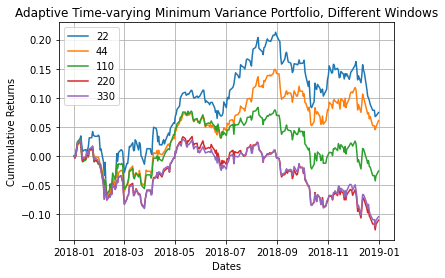

In [53]:
windows =  [22 * i for i in [1, 2, 5, 10, 15]]
adapt_returns = []
variances = []
cum_returns = []

for w in windows:  
    
    adaptive_portfolio = pd.Series(dtype = 'float64') 
    returns_logging = []
    
    for t in test_returns.index: 
        curr_return = returns[:t].iloc[(-w-1):-1] 
        C = curr_return.cov()   
        ones = np.ones(curr_return.shape[1])

        tvar_lambda_test = 1/(ones.T.dot(np.linalg.inv(C).T).dot(ones))
        Lambda = 1/(ones.T.dot(np.linalg.inv(C).T).dot(ones))
        opt_weights = Lambda*(np.linalg.inv(C).dot(ones)).reshape(-1)
        
        adaptive_portfolio[t] = sum(test_returns.loc[t] * opt_weights)  
        returns_logging.append(adaptive_portfolio[t])
        
    # Log returns and variances.
    adapt_returns.append(returns_logging)
    variances.append(adaptive_portfolio.std() ** 2)
    
    plt.plot(adaptive_portfolio.cumsum())
    plt.ylabel('Cummulative Returns')
    plt.xlabel('Dates')
    
    plt.title('Adaptive Time-varying Minimum Variance Portfolio, Different Windows')
    plt.grid(True)
    plt.legend(windows)
    

We see that shorter periods give us better results, generally speaking. With the shorter periods we're able to handle fast market movements better and thus get a better performance. If we consider the 220 and 330 days windows, we see that both are behaving simillarly. So we can conclude that beginning from a certain window size between 110 and 220 there is a size from which on the returns behave strongly simillar to each other.

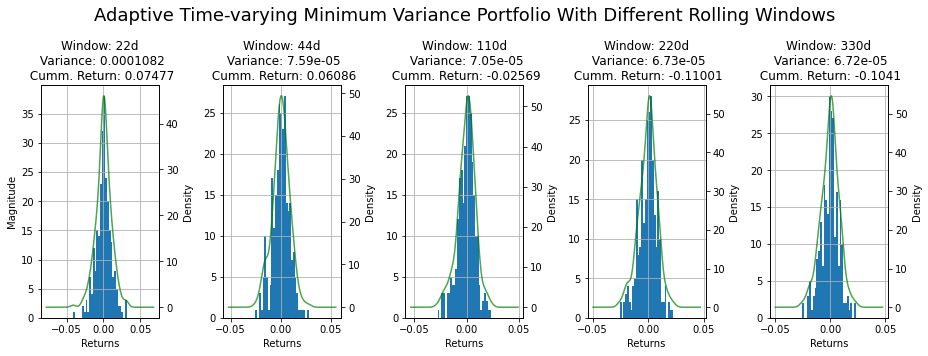

In [54]:
fig, ax = plt.subplots(1,5, figsize = (13, 5))
fig.suptitle("Adaptive Time-varying Minimum Variance Portfolio With Different Rolling Windows", fontsize=18)
ax[0].set_ylabel('Magnitude')

for i in range(len(windows)):
    ax[i].hist(adapt_returns[i], 30)
    ax[i].set_title('Window: '+str(windows[i]) + 'd' + 
                    '\n Variance: ' +str(round(variances[i],7))+
                    '\n Cumm. Return: '+ str(round(sum(adapt_returns[i]),5)))
    adapt_ret_df = pd.DataFrame(adapt_returns[i])
    adapt_ret_df.plot.kde(ax=ax[i].twinx(), color='g', alpha= 0.7, legend = False)
    ax[i].grid()
    ax[i].set_xlabel('Returns')
fig.tight_layout()
    

From all the portfolios analyzed until now, the adaptive time-varying minimum variance portfolio with a time window of 22days performs best with a cummulative return of 7.5%. But the Variance increases. In comparison to e.g. the optimal weights portfolio with a variance of 0.000058.


Thus we see the impact of the weight updating in an increase of the cummulative return.
We could further improve our results with different computations of the sample covariance matrix with giving older dates less weight in comparison to newer ones. Like that we give newer events more importance. Using more data will for sure also benefit the portfolio.

## 4 Robust Statistics and Non Linear Methods

### 4.1 Data Import and Exploratory Data Analysis

#### 4.1.1

In [55]:
# Read price data for AAPL, IBM, JPM and DJI.
stock_names = ['AAPL', 'IBM', 'JPM', 'DJI'] 
AAPL = pd.read_csv('AAPL.csv', index_col = 0) 
IBM = pd.read_csv('IBM.csv', index_col = 0)
JPM = pd.read_csv('JPM.csv', index_col = 0)
DJI = pd.read_csv('DJI.csv', index_col = 0)

AAPL.index = pd.to_datetime(AAPL.index) 
IBM.index = pd.to_datetime(IBM.index)
JPM.index = pd.to_datetime(JPM.index)
DJI.index = pd.to_datetime(DJI.index)

In [56]:
stats_df = pd.DataFrame(index=['Mean', 'Median', 'StdDev', 
                               'Kurtosis', 'Skew'], columns = AAPL.columns)

all_stocks = [AAPL, IBM, JPM, DJI]
statistics = {'AAPL': stats_df.copy(),'IBM': stats_df.copy(),
              'JPM': stats_df.copy(),'DJI': stats_df.copy() }

i = 0

for stock in all_stocks:
    for column in stock.columns:
        statistics[stock_names[i]][column]['Mean'] = stock[column].mean()
        statistics[stock_names[i]][column]['Median'] = stock[column].median()
        statistics[stock_names[i]][column]['StdDev'] = stock[column].std()
        statistics[stock_names[i]][column]['Kurtosis'] = stock[column].kurtosis()
        statistics[stock_names[i]][column]['Skew'] = stock[column].skew()
    
    # add the return as a column
    stock['Return'] = stock['Adj Close'].pct_change()
    
    i = i+1


In [57]:
AAPL.head()

Open        High         Low       Close   Adj Close  \
Date                                                                     
2018-03-16  178.649994  179.119995  177.619995  178.020004  175.349915   
2018-03-19  177.320007  177.470001  173.660004  175.300003  172.670731   
2018-03-20  175.240005  176.800003  174.940002  175.240005  172.611618   
2018-03-21  175.039993  175.089996  171.259995  171.270004  168.701157   
2018-03-22  170.000000  172.679993  168.600006  168.850006  166.317459   

              Volume    Return  
Date                            
2018-03-16  39404700       NaN  
2018-03-19  33446800 -0.015279  
2018-03-20  19649400 -0.000342  
2018-03-21  36338100 -0.022655  
2018-03-22  41490800 -0.014130

In [58]:
statistics['AAPL']

Open        High         Low       Close   Adj Close  \
Mean      187.686694  189.561753  185.823705  187.711953  186.174273   
Median    186.289993  187.399994  184.940002  186.119995  184.351776   
StdDev     22.145621   22.281577   22.008797   22.160721   21.904664   
Kurtosis   -0.912594   -0.924602   -0.917632   -0.932425   -0.928017   
Skew        0.259917    0.300385    0.220489    0.263849     0.29077   

                   Volume  
Mean      32704750.199203  
Median         29184000.0  
StdDev    14179721.592994  
Kurtosis         4.353182  
Skew             1.743317

In [59]:
statistics['IBM']

Open        High         Low       Close   Adj Close  \
Mean      138.454382  139.492072  137.329243  138.363108  134.902751   
Median    142.809998  143.990005  142.059998  142.710007  138.566391   
StdDev     12.114308   11.913079   12.204633   12.028123   10.671648   
Kurtosis   -0.585272   -0.623607   -0.561975   -0.584037   -0.420852   
Skew       -0.676024   -0.622707   -0.713446   -0.682246   -0.811222   

                  Volume  
Mean      5198937.450199  
Median         4237900.0  
StdDev    3328955.530426  
Kurtosis       11.796897  
Skew            3.192896

In [60]:
statistics['JPM']

Open        High         Low       Close   Adj Close  \
Mean      108.707689  109.652072  107.682988  108.606574   107.26259   
Median        109.18  110.529999  107.790001  109.019997  107.219269   
StdDev      5.359081     5.20287    5.432537     5.30048    4.833316   
Kurtosis   -0.322536   -0.544163     -0.2657   -0.396579   -0.105437   
Skew       -0.420811   -0.376221   -0.377517   -0.374853   -0.344491   

                   Volume  
Mean      14700689.243028  
Median         13633000.0  
StdDev     5349770.564456  
Kurtosis         4.430197  
Skew             1.693457

In [61]:
statistics['DJI']

Open          High           Low         Close  \
Mean      25001.257268  25142.041965  24846.002226  24999.153581   
Median    25025.580078  25124.099609  24883.039063  25044.289063   
StdDev      858.834708    815.203959    903.302186    859.132105   
Kurtosis      0.485736      0.118153      0.557592      0.400668   
Skew         -0.372127     -0.239367     -0.456447     -0.380147   

             Adj Close            Volume  
Mean      24999.153581  332889442.231076  
Median    25044.289063       313790000.0  
StdDev      859.132105    94078038.14115  
Kurtosis      0.400668          5.857581  
Skew         -0.380147           1.73956

#### 4.1.2

Bellow you find the histograms of the Returns and the Adj. Closure prices of the stocks with a fitted curve resulting from Kernel Density Estimation (KDE). This KDE is done with the `DataFrame.plot.kde` function. 

We see that the returns are distributed nearly gaussian normal, while the Adj. Closure prices need some more difficult gaussian fitting. This reflects what we saw in section 1, that returns tend to be normal distributed.
There is a mentionable difference between the Adj. Closure prices of AAPL and IBM in comparison to JPM and DJI. DJI and JPM seem to have more stable Adj. Closure prices and have a smaller variance. This could be the case, since the banking sector is not as volatile as the tech sector, and since DJI is an index and indexes tend to have lower volatility because of diversification.

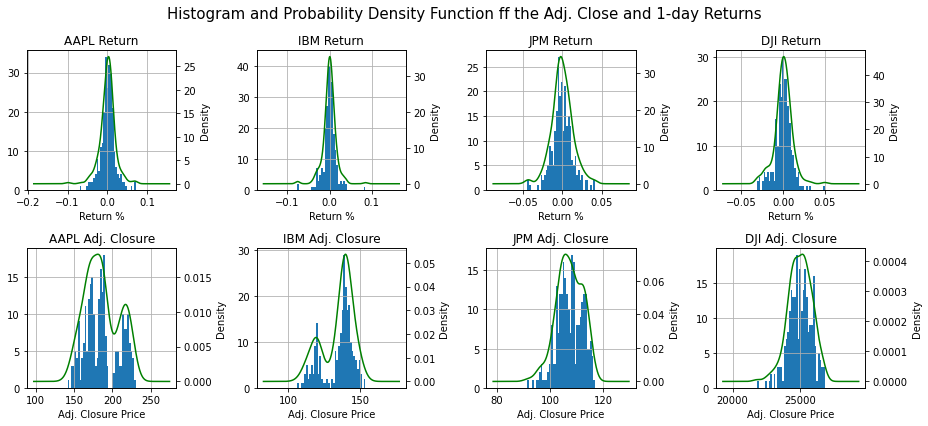

In [62]:
fig, ax = plt.subplots(2,4)
fig.suptitle('Histogram and Probability Density Function ff the Adj. Close and 1-day Returns', fontsize= 15)
fig.set_size_inches(13,6)

for i, stock in enumerate(all_stocks):
    ax[0][i].hist(stock['Return'], bins = 40)
    ax[1][i].hist(stock['Adj Close'], bins = 40)
    ax[0][i].set_title(stock_names[i] + ' Return')
    ax[1][i].set_title(stock_names[i] + ' Adj. Closure')
    ax[0][i].set_xlabel('Return %')
    ax[1][i].set_xlabel('Adj. Closure Price')
    ax[0][i].grid()
    ax[1][i].grid()
    stock['Return'].plot.kde(ax=ax[0][i].twinx(), color='g')
    stock['Adj Close'].plot.kde(ax=ax[1][i].twinx(), color='g')
    
fig.tight_layout()    

#### 4.1.3

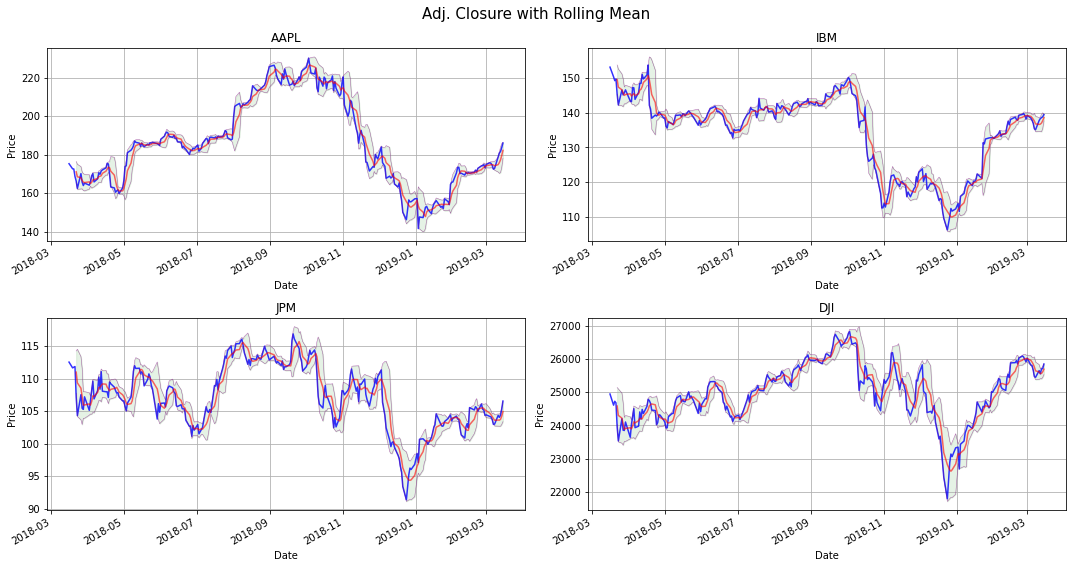

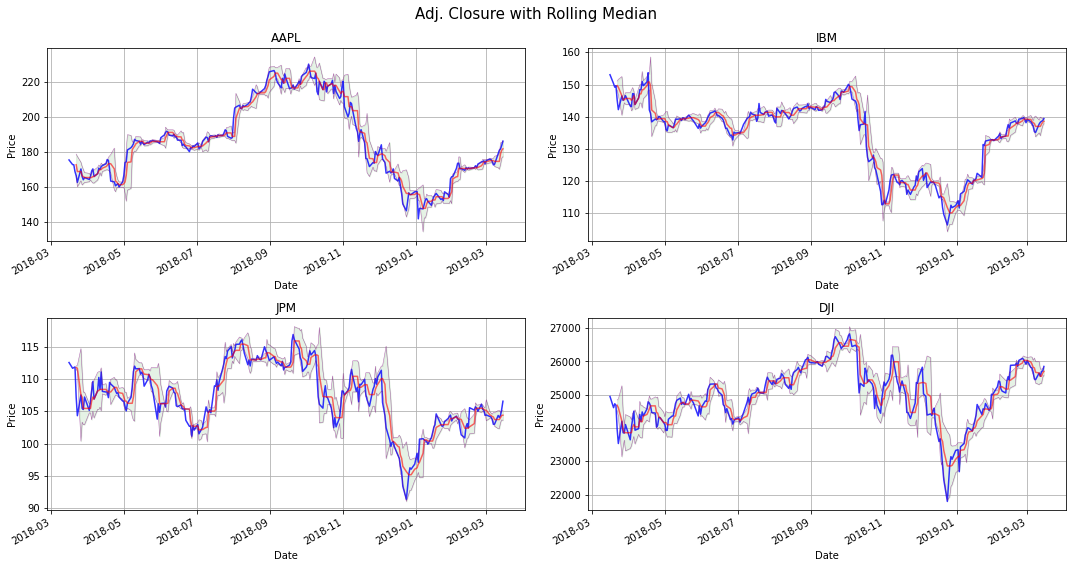

In [63]:
fig, ax = plt.subplots(2,2)
fig.set_size_inches(15,8)
fig.suptitle('Adj. Closure with Rolling Mean', fontsize= 15)

fig2, ax2 = plt.subplots(2,2)
fig2.set_size_inches(15,8)
fig2.suptitle('Adj. Closure with Rolling Median', fontsize= 15)

for i, stock in enumerate(all_stocks):
    if i > 1:
        j=1
    else:
        j=0
    
    stock_rolling_mean = stock['Adj Close'].rolling(5).mean()
    stock_rolling_median = stock['Adj Close'].rolling(5).median()
    stock_rolling_std = stock['Adj Close'].rolling(5).std()
    stock_rolling_mad = stock['Adj Close'].rolling(5).apply(mad)
    upper_bound_mean = stock_rolling_mean + 1.5* stock_rolling_std
    lower_bound_mean = stock_rolling_mean - 1.5* stock_rolling_std
    upper_bound_median = stock_rolling_median + 1.5* stock_rolling_mad
    lower_bound_median = stock_rolling_median - 1.5* stock_rolling_mad


    stock['Adj Close'].plot(ax = ax[j][i%2], grid = True, 
                            title = stock_names[i], ylabel= 'Price', color='blue', alpha= 0.8)
    ax[j][i%2].plot(stock_rolling_mean, alpha = 0.6, color ='r')
    ax[j][i%2].plot(upper_bound_mean, alpha = 0.6, color ='purple', linewidth=0.5)
    ax[j][i%2].plot(lower_bound_mean, alpha = 0.6, color ='purple', linewidth=0.5)
    ax[j][i%2].fill_between(stock_rolling_mean.index, upper_bound_mean, 
                            lower_bound_mean, color = 'g', alpha = 0.1)
    
    stock['Adj Close'].plot(ax = ax2[j][i%2], grid = True, 
                            title = stock_names[i], ylabel= 'Price', color='blue', alpha= 0.8)
    ax2[j][i%2].plot(stock_rolling_median, alpha = 0.6, color ='r')
    ax2[j][i%2].plot(upper_bound_median, alpha = 0.6, color ='purple', linewidth=0.5)
    ax2[j][i%2].plot(lower_bound_median, alpha = 0.6, color ='purple', linewidth=0.5)
    ax2[j][i%2].fill_between(stock_rolling_median.index, upper_bound_median, 
                            lower_bound_median, color = 'g', alpha = 0.1)
    
    
fig.tight_layout()    
fig2.tight_layout()   



Observations: The bounds computed with the mean are often times not as strict as the ones calculated with the median and are also smoother. The Median Bounds have many more spikes n comparison to the mean. 

#### 4.1.4

Now we introduce outlier points into our data.

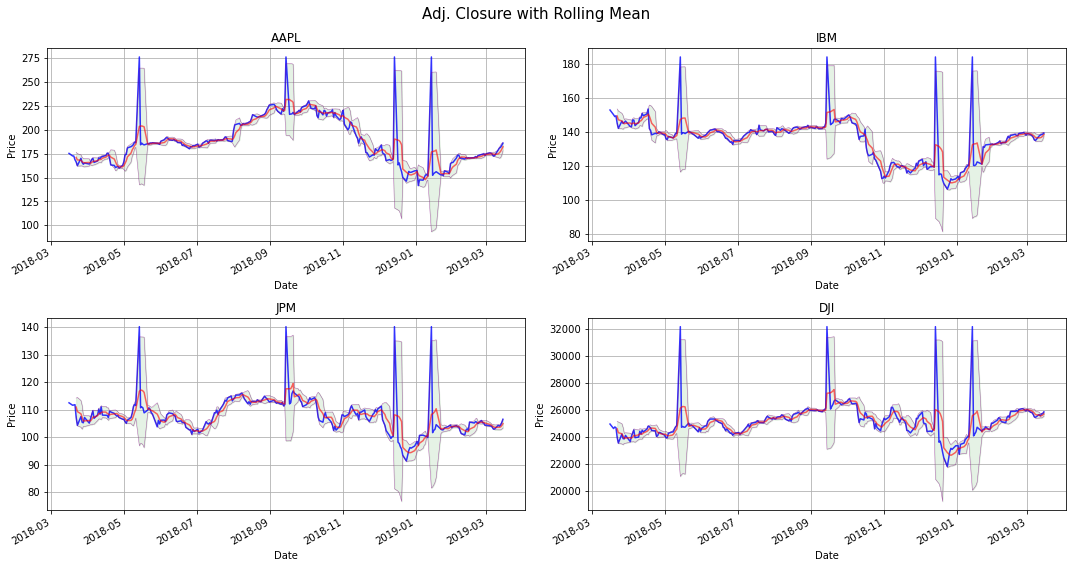

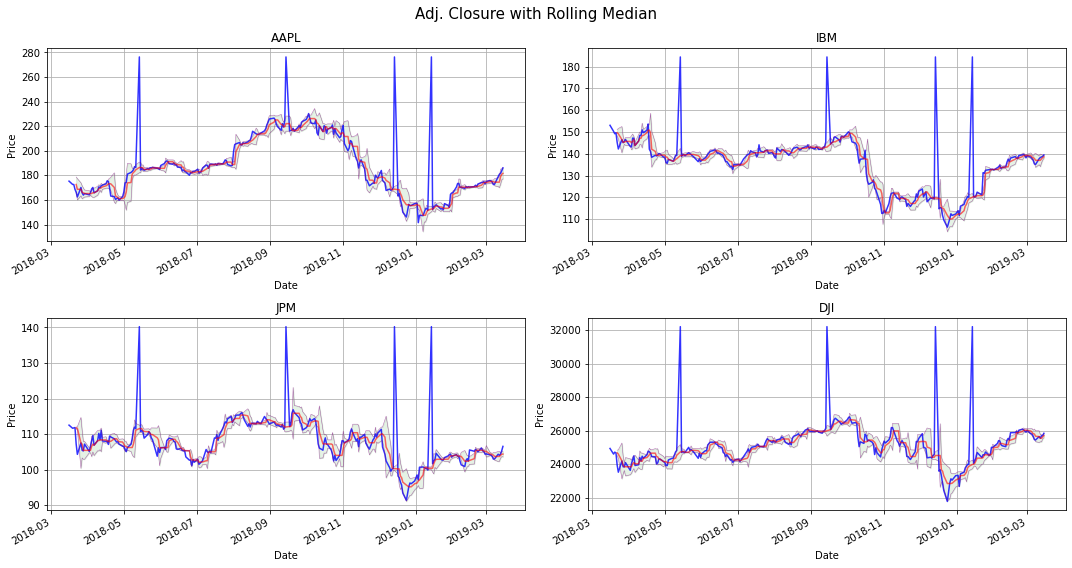

In [64]:
outlier_dates = ['2018-05-14', '2018-09-14', '2018-12-14', '2019-01-14']

fig, ax = plt.subplots(2,2)
fig.set_size_inches(15,8)
fig.suptitle('Adj. Closure with Rolling Mean', fontsize= 15)

fig2, ax2 = plt.subplots(2,2)
fig2.set_size_inches(15,8)
fig2.suptitle('Adj. Closure with Rolling Median', fontsize= 15)

for i, stock in enumerate(all_stocks):
    if i > 1:
        j=1
    else:
        j=0
        
    stock_modified = stock.copy()
    outliers_value = stock_modified['Adj Close'].max()*1.2
    
    for date in outlier_dates:
        stock_modified['Adj Close'][date] = outliers_value
    
    stock_rolling_mean = stock_modified['Adj Close'].rolling(5).mean()
    stock_rolling_median = stock_modified['Adj Close'].rolling(5).median()
    stock_rolling_std = stock_modified['Adj Close'].rolling(5).std()
    stock_rolling_mad = stock_modified['Adj Close'].rolling(5).apply(mad)
    upper_bound_mean = stock_rolling_mean + 1.5* stock_rolling_std
    lower_bound_mean = stock_rolling_mean - 1.5* stock_rolling_std
    upper_bound_median = stock_rolling_median + 1.5* stock_rolling_mad
    lower_bound_median = stock_rolling_median - 1.5* stock_rolling_mad


    stock_modified['Adj Close'].plot(ax = ax[j][i%2], grid = True, 
                            title = stock_names[i], ylabel= 'Price', color='blue', alpha= 0.8)
    ax[j][i%2].plot(stock_rolling_mean, alpha = 0.6, color ='r')
    ax[j][i%2].plot(upper_bound_mean, alpha = 0.6, color ='purple', linewidth=0.5)
    ax[j][i%2].plot(lower_bound_mean, alpha = 0.6, color ='purple', linewidth=0.5)
    ax[j][i%2].fill_between(stock_rolling_mean.index, upper_bound_mean, 
                            lower_bound_mean, color = 'g', alpha = 0.1)
    
    stock_modified['Adj Close'].plot(ax = ax2[j][i%2], grid = True, 
                            title = stock_names[i], ylabel= 'Price', color='blue', alpha= 0.8)
    ax2[j][i%2].plot(stock_rolling_median, alpha = 0.6, color ='r')
    ax2[j][i%2].plot(upper_bound_median, alpha = 0.6, color ='purple', linewidth=0.5)
    ax2[j][i%2].plot(lower_bound_median, alpha = 0.6, color ='purple', linewidth=0.5)
    ax2[j][i%2].fill_between(stock_rolling_median.index, upper_bound_median, 
                            lower_bound_median, color = 'g', alpha = 0.1)
    
    
fig.tight_layout()    
fig2.tight_layout()   


We see that the rolling median bounds work better, since they don't respond to the added outliers. On the other hand the rolling mean tries to include the outliers in the upper and lower bounds and therefore we get the big surfaces next to the outliers. Therefore we conclude that for this scenario the median is more robust to outlier detection than the mean.

#### 4.1.5

In a box plot the minimum, first quartile, median, third quartile and maximum are depicted. The box extends from the lower to upper quartile values of the data. The orange line is at the median. The whiskers that extend from the box are showing the range of the data. Outlier points are those past the end of the whiskers depicted by a circle.

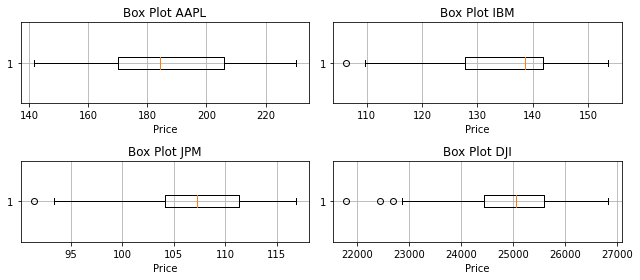

In [65]:
fig, axes = plt.subplots(2, 2)
fig.set_size_inches(9,4)
fig.tight_layout()

for i, stock in enumerate(all_stocks):
    if i > 1:
        j=1
    else:
        j=0
    axes[j][i%2].boxplot(stock['Adj Close'], vert=False, )
    axes[j][i%2].set_title('Box Plot ' + stock_names[i])
    axes[j][i%2].grid()
    axes[j][i%2].set_xlabel('Price')

fig.tight_layout()

We see that AAPL has the largest upper to lower quartile values therefore having the highest volatility. We also see that the median of  IBM is strongly skewed towards the upper quartile.

### 4.2 Robust Estimators

This section involves the implementation, analysis and assessment of the following estimators:

• Robust location estimator: median

• Robust scale estimator: IQR (Interquartile range) and MAD (Median Absolute Deviation)

#### 4.2.1

In [66]:
def robust_location_estimator_median(data):
    data = data.sort_values()
    return data[round(data.size()/2)]
    
def robust_scale_estimator_iqr(data):
    data = data.sort_values()
    return data[round(data.size()/4*3)] - data[round(data.size()/7)]
        
def robust_scale_estimator_mad(data):
    median = robust_location_estimator_median(data)
    return robust_location_estimator_median(abs(data - median))

#### 4.2.2

Since pandas uses quicksort as default sorting algorithm for `sort_values()` we have a Best-case performane of $O(nlogn)$ and worst case of $O(n^2)$ for the sorting part.

Thus we get the following complexities:

$\textbf{Median}$:
Since the median lookup only needs $O(1)$ the function `robust_location_estimator_median` has the following running time complexities: 

best case of $O(nlog(n)+1) = O(nlog(n))$ as $ n \rightarrow ∞ $ 

worst case of $O(n^2+1) = O(n^2)$ as $ n \rightarrow ∞ $

$\textbf{IQR}$:
Since the IQR lookup only needs two lookups i.e. $O(1)$ the function `robust_scale_estimator_iqr` has the following running time complexities:  

best case of $O(nlog(n)+1) = O(nlog(n))$ as $ n \rightarrow ∞ $ 

worst case of $O(n^2+1) = O(n^2)$ as $ n \rightarrow ∞ $

$\textbf{MAD}$:
Here we have to calculate the median two times and also get an added complexity of $O(n)$ because for each datapoint in `data` we have to calculate a subtraction.
Therefore the function `robust_scale_estimator_mad` has the following running time complexities: 

best case of $O(2* nlog(n) + n) = O(nlog(n))$ as $ n \rightarrow ∞ $ 

worst case of $O(2* n^2+n+1) = O(n^2)$ as $ n \rightarrow ∞ $

#### 4.2.3

As defined in the lecture: "Maximum allowed fraction of outliers that an estimator can tolerate", we analyze the breakdown point of the above algorithms.
For the median estimator we can conclude that having n data points and changing just the upper or lower half of the points won't change the median. Formally speaking this means that our breakdown point is at 0.5 since:
$$ \lim_{n \to ∞}\frac{0.5 n-1}{n} = 0.5 $$

Since $ 0.5n-1 $ is the amount of point we are allowed to change.

For the IQR we can simplify the poblem to having split the data in two parts and taking the median of each part. Therefore we get a breaking point of 0.25 according to the reasoning above.

For the MAD we get the same breakdown point as for the median, since we take the median and then we calculate the absolute deviation from the median and since the median has a breakdown point of 0.5, we get also a breakdown point of 0.5 for MAD.


### 4.3 Robust and OLS Regression

#### 4.3.1

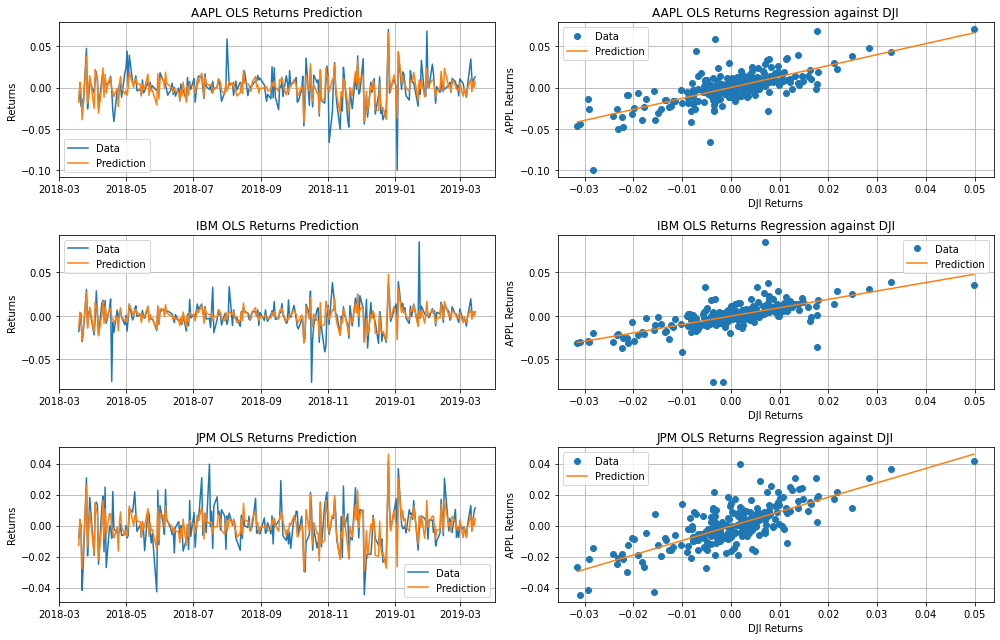

In [67]:
# we only want returns
returns = pd.DataFrame(columns = stock_names)

for i, stock in enumerate(all_stocks):
    returns[stock_names[i]] = stock['Return'].dropna()
    
regression_model_ols = linear_model.LinearRegression()
regressed_values = pd.DataFrame(columns=stock_names, index=['alpha', 'beta', 'mse'])

fig, ax = plt.subplots(3,2)
fig.set_size_inches(14,9)

x = returns['DJI'].copy().values.reshape(-1,1)
linspace_x = np.linspace(x.min(), x.max())

for i,stock in enumerate(stock_names[:-1]):
    y = returns[stock].copy().values.reshape(-1,1)
    regression_model_ols.fit(x, y)
    coef = regression_model_ols.coef_ * linspace_x + regression_model_ols.intercept_
    regressed_values[stock]['alpha'] = float(regression_model_ols.intercept_)
    regressed_values[stock]['beta'] = float(regression_model_ols.coef_)

    pred = regression_model_ols.predict(x)
    regressed_values[stock]['mse'] = mean_squared_error(y, pred)
    ax[i][0].plot(returns[stock].index, y)
    ax[i][0].plot(returns[stock].index, pred)
    ax[i][0].legend(['Data','Prediction'])
    ax[i][0].set_title(stock + ' OLS Returns Prediction')
    ax[i][0].set_ylabel('Returns')
    ax[i][0].grid()
    
    ax[i][1].plot(x, y, 'o')
    ax[i][1].plot(linspace_x, coef.reshape(-1))
    ax[i][1].legend(['Data','Prediction'])
    ax[i][1].set_title(stock + ' OLS Returns Regression against DJI')
    ax[i][1].set_ylabel('APPL Returns')
    ax[i][1].set_xlabel('DJI Returns')
    ax[i][1].grid()
fig.tight_layout()
    

#### 4.3.2

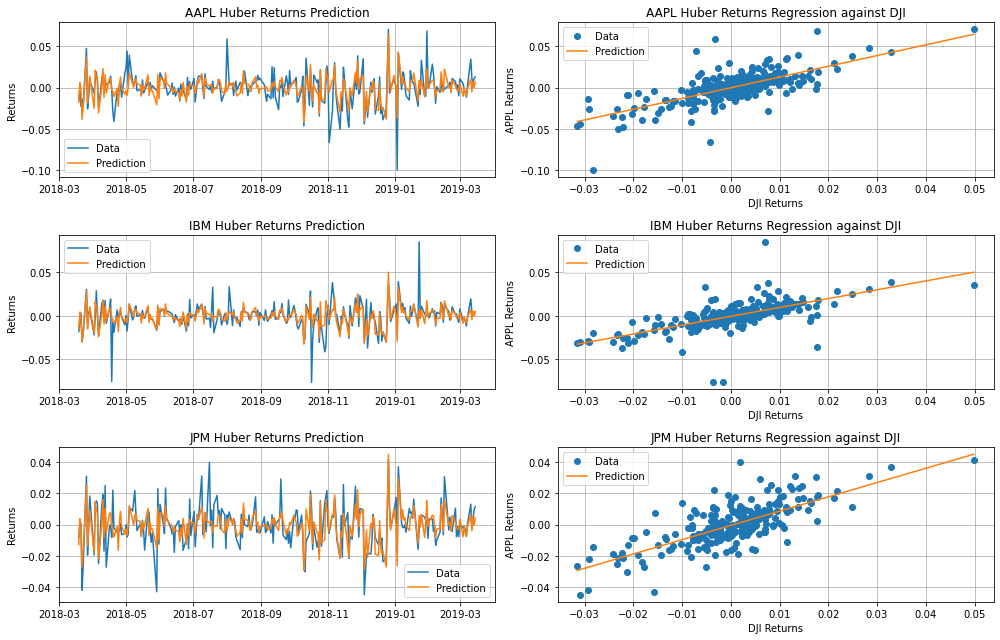

In [68]:
regression_model_hub = linear_model.HuberRegressor(epsilon=1.0)
regressed_values_hub = pd.DataFrame(columns=stock_names, index=['alpha', 'beta', 'mse'])

fig, ax = plt.subplots(3,2)
fig.set_size_inches(14,9)

x = returns['DJI'].copy().values.reshape(-1,1)

for i,stock in enumerate(stock_names[:-1]):
    y = returns[stock].copy().values.reshape(-1,1)
    regression_model_hub.fit(x, y)
    coef = regression_model_hub.coef_ * linspace_x + regression_model_hub.intercept_
    regressed_values_hub[stock]['alpha'] = float(regression_model_hub.intercept_)
    regressed_values_hub[stock]['beta'] = float(regression_model_hub.coef_)

    pred = regression_model_hub.predict(x)
    regressed_values_hub[stock]['mse'] = mean_squared_error(y, pred)
    ax[i][0].plot(returns[stock].index, y)
    ax[i][0].plot(returns[stock].index, pred)
    ax[i][0].legend(['Data','Prediction'])
    ax[i][0].set_title(stock + ' Huber Returns Prediction')
    ax[i][0].set_ylabel('Returns')
    ax[i][0].grid()
    
    ax[i][1].plot(x, y, 'o')
    ax[i][1].plot(linspace_x, coef.reshape(-1))
    ax[i][1].legend(['Data','Prediction'])
    ax[i][1].set_title(stock + ' Huber Returns Regression against DJI')
    ax[i][1].set_ylabel('APPL Returns')
    ax[i][1].set_xlabel('DJI Returns')
    ax[i][1].grid()
plt.tight_layout()

In [69]:
regressed_values

AAPL       IBM       JPM  DJI
alpha  0.000165 -0.000441 -0.000316  NaN
beta    1.32558  0.960092  0.931408  NaN
mse     0.00018   0.00014  0.000076  NaN

In [70]:
regressed_values_hub_raw = regressed_values_hub

In [71]:
regressed_values-regressed_values_hub

AAPL       IBM       JPM  DJI
alpha  0.000314  0.000188  0.000169  NaN
beta   0.027652 -0.052258  0.022221  NaN
mse        -0.0      -0.0      -0.0  NaN

#### 4.3.3

For the outlier comparison we take again the data from before where we introduced 4 outliers. We predict the returns with both models.

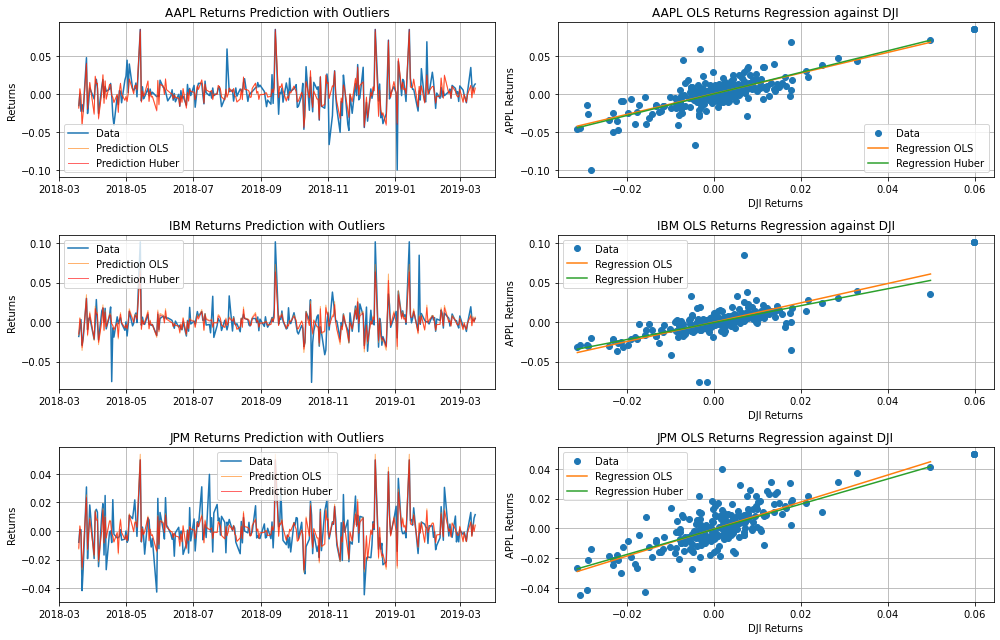

In [72]:
returns = pd.DataFrame(columns = stock_names)
regressed_values_ols = pd.DataFrame(columns=stock_names, index=['alpha', 'beta', 'mse'])
regressed_values_hub = pd.DataFrame(columns=stock_names, index=['alpha', 'beta', 'mse'])

for i, stock in enumerate(all_stocks):
    stock_modified = stock.copy()
    
    outliers_value_ret = stock_modified['Return'].max()*1.2
    
    for date in outlier_dates:
        stock_modified['Return'][date] = outliers_value_ret
    
    returns[stock_names[i]] = stock_modified['Return'].dropna()

# models
regression_model_ols = linear_model.LinearRegression()
regressed_values_ols = pd.DataFrame(columns=stock_names, index=['alpha', 'beta', 'mse'])
regression_model_hub = linear_model.HuberRegressor(epsilon=1.0)
regressed_values_hub = pd.DataFrame(columns=stock_names, index=['alpha', 'beta', 'mse'])

# plot
fig, ax = plt.subplots(3,2)
fig.set_size_inches(14,9)

x = returns['DJI'].copy().values.reshape(-1,1)

for i,stock in enumerate(stock_names[:-1]):
    y = returns[stock].copy().values.reshape(-1,1)
    
    regression_model_ols.fit(x, y)
    coef = regression_model_ols.coef_ * linspace_x + regression_model_ols.intercept_
    regressed_values_ols[stock]['alpha'] = float(regression_model_ols.intercept_)
    regressed_values_ols[stock]['beta'] = float(regression_model_ols.coef_)
    
    regression_model_hub.fit(x, y)
    coef_hub = regression_model_hub.coef_ * linspace_x + regression_model_hub.intercept_
    regressed_values_hub[stock]['alpha'] = float(regression_model_hub.intercept_)
    regressed_values_hub[stock]['beta'] = float(regression_model_hub.coef_)

    pred_ols = regression_model_ols.predict(x)
    pred_hub = regression_model_hub.predict(x)
    regressed_values_ols[stock]['mse'] = mean_squared_error(y, pred_ols)
    regressed_values_hub[stock]['mse'] = mean_squared_error(y, pred_hub)
    ax[i][0].plot(returns[stock].index, y)
    ax[i][0].plot(returns[stock].index, pred_ols, alpha = 0.6, linewidth = 1)
    ax[i][0].plot(returns[stock].index, pred_hub, alpha = 0.6, color ='r', linewidth = 1)
    ax[i][0].legend(['Data','Prediction OLS', 'Prediction Huber'])
    ax[i][0].set_title(stock + ' Returns Prediction with Outliers')
    ax[i][0].set_ylabel('Returns')
    ax[i][0].grid()
    
    ax[i][1].plot(x, y, 'o')
    ax[i][1].plot(linspace_x, coef.reshape(-1))
    ax[i][1].plot(linspace_x, coef_hub.reshape(-1))
    ax[i][1].legend(['Data','Regression OLS', 'Regression Huber'])
    ax[i][1].set_title(stock + ' OLS Returns Regression against DJI')
    ax[i][1].set_ylabel('APPL Returns')
    ax[i][1].set_xlabel('DJI Returns')
    ax[i][1].grid()
    
fig.tight_layout()

In [73]:
(regressed_values_ols-regressed_values).sum(1)

alpha    0.000413
beta     0.261892
mse      0.000017
dtype: float64

In [74]:
(regressed_values_hub-regressed_values_hub_raw).sum(1)

alpha    0.000096
beta     0.106542
mse      0.000022
dtype: float64

We can see that the alphas and betas are pretty different, but the MSE is simillar. The models are predicting the outliers reliably, but the OLS regressor often overestimates the outlier whereas the Huber regressor predicts it more robustly.

### 4.4 Robust Trading Strategies

#### 4.4.1

Bellow you find the plots of the return including the 20 day and 50 day moving averages. The first plot is without outliers and the second includes some artificial outliers. 

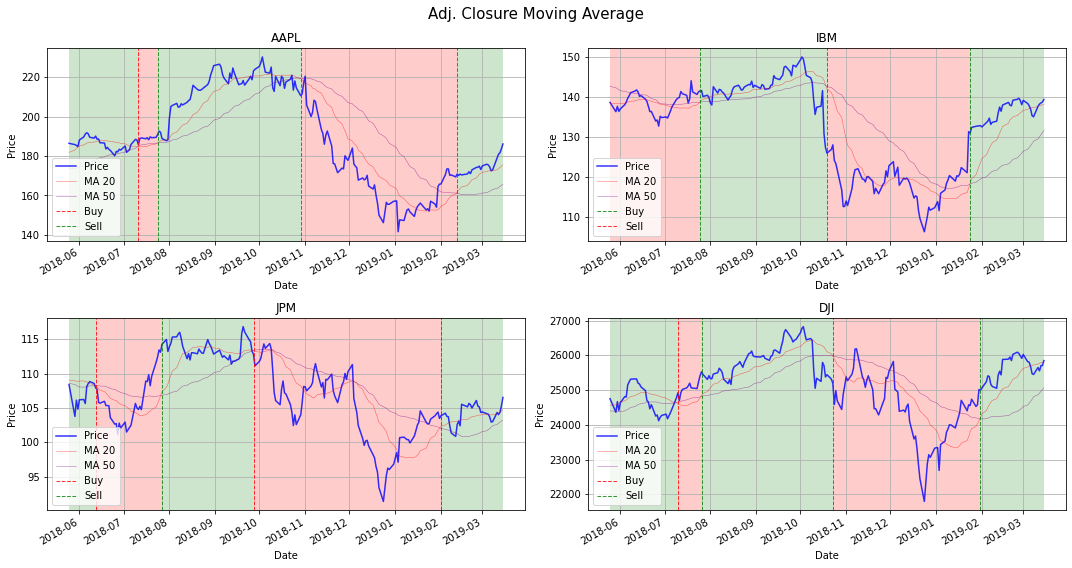

In [75]:
fig, ax = plt.subplots(2,2)
fig.set_size_inches(15,8)
fig.suptitle('Adj. Closure Moving Average', fontsize= 15)


for i, stock in enumerate(all_stocks):
    if i > 1:
        j=1
    else:
        j=0
    
    stock_rolling_20 = stock['Adj Close'].rolling(20).mean()
    stock_rolling_50 = stock['Adj Close'].rolling(50).mean()
    stock_buying = np.sign((stock_rolling_20 - stock_rolling_50).dropna())
    stock_buying.index = pd.to_datetime(stock_rolling_20.index[49:])

    stock['Adj Close'][49:].plot(ax = ax[j][i%2], grid = True, 
                            title = stock_names[i], ylabel= 'Price', color='blue', alpha= 0.8)
    ax[j][i%2].plot(stock_rolling_20[49:], alpha = 0.6, color ='r', linewidth=0.5, label='MA 20')
    ax[j][i%2].plot(stock_rolling_50, alpha = 0.6, color ='purple', linewidth=0.5, label='MA 50')
    sign_before = stock_buying[0]
    
    for z, value in enumerate(stock_buying[:-1]):
        if value > 0:
            if sign_before == -1:
                ax[j][i%2].axvline(stock_buying.index[z], linestyle = '--', linewidth = 1, 
                                   alpha = 0.8, color = 'green', label = 'Buy')
                sign_before = 1
            ax[j][i%2].axvspan(stock_buying.index[z], stock_buying.index[z+1], 
                               facecolor='g', alpha=0.2)
        else:
            if sign_before == 1:
                ax[j][i%2].axvline(stock_buying.index[z], linestyle = '--', linewidth = 1, 
                                   alpha = 0.8, color = 'red', label = 'Sell')
                sign_before = -1
            ax[j][i%2].axvspan(stock_buying.index[z], stock_buying.index[z+1], 
                               facecolor='r', alpha=0.2)

    ax[j][i%2].legend(['Price','MA 20','MA 50','Buy','Sell'], loc='lower left')

fig.tight_layout()    

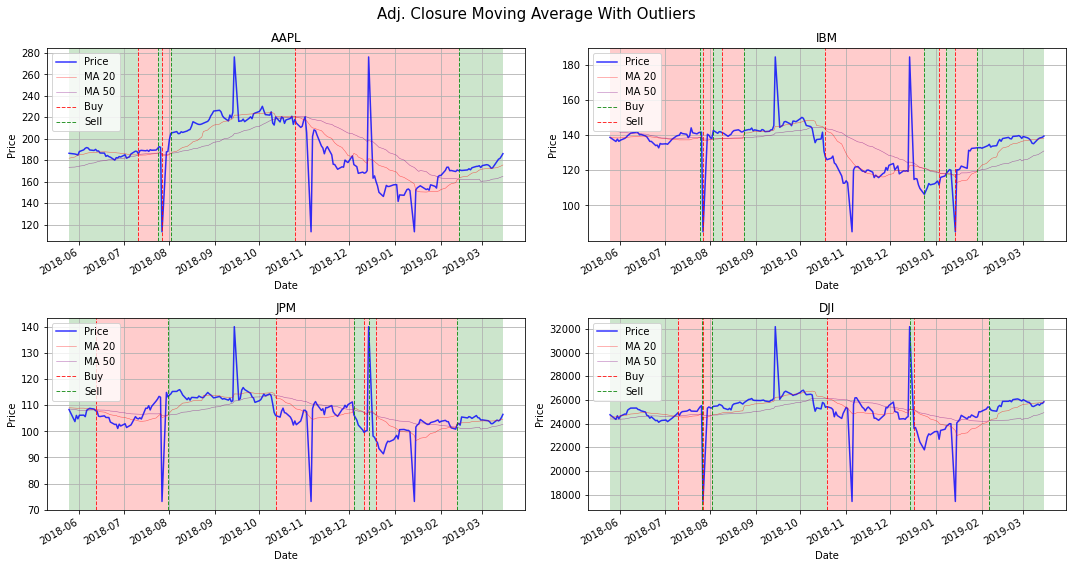

In [76]:
fig, ax = plt.subplots(2,2)
fig.set_size_inches(15,8)
fig.suptitle('Adj. Closure Moving Average With Outliers', fontsize= 15)
outlier_dates = ['2018-07-27', '2018-09-14', '2018-11-5', '2018-12-14', '2019-01-14']

for i, stock in enumerate(all_stocks):
    if i > 1:
        j=1
    else:
        j=0
        
    stock_modified = stock.copy()
    outliers_value_max = stock_modified['Adj Close'].max()
    outliers_value_min = stock_modified['Adj Close'].min()
    
    for counter, date in enumerate(outlier_dates):
        if counter%2 == 1:
            current_value = outliers_value_max*1.2
        else:
            current_value = outliers_value_min*0.8
            
        stock_modified['Adj Close'][date] = current_value
    
    stock_rolling_20 = stock_modified['Adj Close'].rolling(20).mean()
    stock_rolling_50 = stock_modified['Adj Close'].rolling(50).mean()
    stock_buying = np.sign((stock_rolling_20 - stock_rolling_50).dropna())
    stock_buying.index = pd.to_datetime(stock_rolling_20.index[49:])

    stock_modified['Adj Close'][49:].plot(ax = ax[j][i%2], grid = True, 
                            title = stock_names[i], ylabel= 'Price', color='blue', alpha= 0.8)
    ax[j][i%2].plot(stock_rolling_20[49:], alpha = 0.6, color ='r', linewidth=0.5, label='MA 20')
    ax[j][i%2].plot(stock_rolling_50, alpha = 0.6, color ='purple', linewidth=0.5, label='MA 50')
    sign_before = stock_buying[0]
    
    for z, value in enumerate(stock_buying[:-1]):
        if value > 0:
            if sign_before == -1:
                ax[j][i%2].axvline(stock_buying.index[z], linestyle = '--', linewidth = 1, 
                                   alpha = 0.8, color = 'green', label = 'Buy')
                sign_before = 1
            ax[j][i%2].axvspan(stock_buying.index[z], stock_buying.index[z+1], 
                               facecolor='g', alpha=0.2)
        else:
            if sign_before == 1:
                ax[j][i%2].axvline(stock_buying.index[z], linestyle = '--', linewidth = 1, 
                                   alpha = 0.8, color = 'red', label = 'Sell')
                sign_before = -1
            ax[j][i%2].axvspan(stock_buying.index[z], stock_buying.index[z+1], 
                               facecolor='r', alpha=0.2)

    ax[j][i%2].legend(['Price','MA 20','MA 50','Buy','Sell'], loc='upper left')

fig.tight_layout()    

We can see a big difference in comparison to the data without outliers. There are several occasions where we change the strategy from buying to selling or vice versa in comparison to the graphs without outliers. This shows that the mean is not robust against outliers.

#### 4.4.2

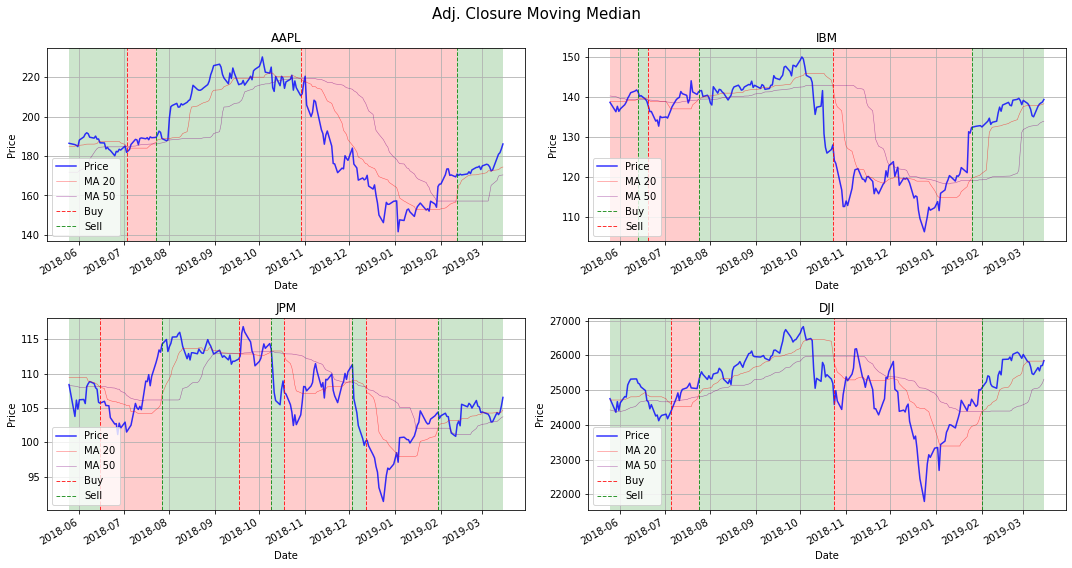

In [77]:
fig, ax = plt.subplots(2,2)
fig.set_size_inches(15,8)
fig.suptitle('Adj. Closure Moving Median', fontsize= 15)

for i, stock in enumerate(all_stocks):
    if i > 1:
        j=1
    else:
        j=0
    
    stock_rolling_20 = stock['Adj Close'].rolling(20).median()
    stock_rolling_50 = stock['Adj Close'].rolling(50).median()
    stock_buying = np.sign((stock_rolling_20 - stock_rolling_50).dropna())
    stock_buying.index = pd.to_datetime(stock_rolling_20.index[49:])

    stock['Adj Close'][49:].plot(ax = ax[j][i%2], grid = True, 
                            title = stock_names[i], ylabel= 'Price', color='blue', alpha= 0.8)
    ax[j][i%2].plot(stock_rolling_20[49:], alpha = 0.6, color ='r', linewidth=0.5, label='MA 20')
    ax[j][i%2].plot(stock_rolling_50, alpha = 0.6, color ='purple', linewidth=0.5, label='MA 50')
    sign_before = stock_buying[0]
    
    for z, value in enumerate(stock_buying[:-1]):
        if value > 0:
            if sign_before == -1:
                ax[j][i%2].axvline(stock_buying.index[z], linestyle = '--', linewidth = 1, 
                                   alpha = 0.8, color = 'green', label = 'Buy')
                sign_before = 1
            ax[j][i%2].axvspan(stock_buying.index[z], stock_buying.index[z+1], 
                               facecolor='g', alpha=0.2)
        else:
            if sign_before == 1:
                ax[j][i%2].axvline(stock_buying.index[z], linestyle = '--', linewidth = 1, 
                                   alpha = 0.8, color = 'red', label = 'Sell')
                sign_before = -1
            ax[j][i%2].axvspan(stock_buying.index[z], stock_buying.index[z+1], 
                               facecolor='r', alpha=0.2)

    ax[j][i%2].legend(['Price','MA 20','MA 50','Buy','Sell'], loc='lower left')

fig.tight_layout()    

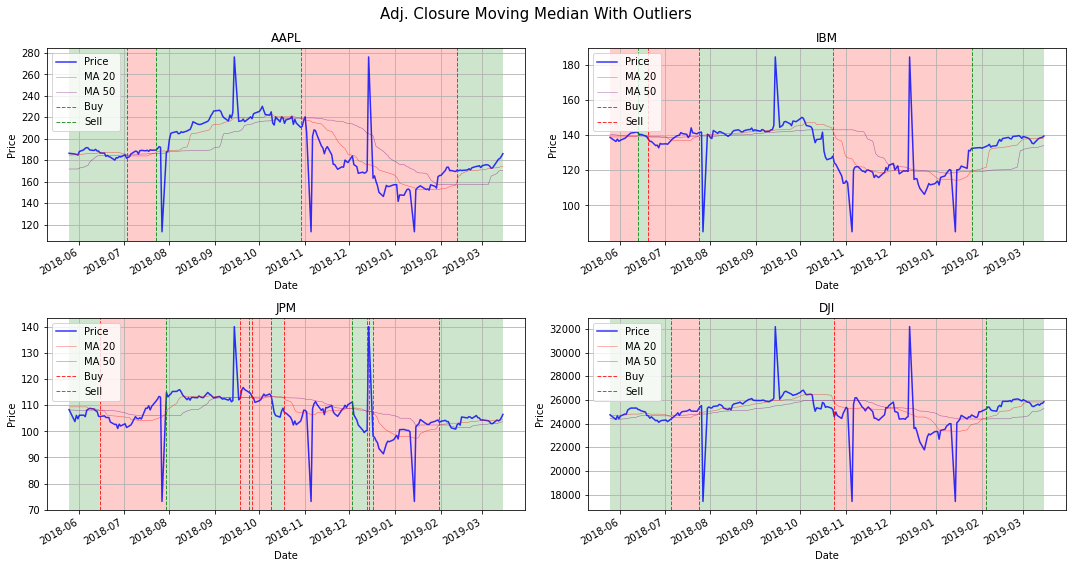

In [78]:
fig, ax = plt.subplots(2,2)
fig.set_size_inches(15,8)
fig.suptitle('Adj. Closure Moving Median With Outliers', fontsize= 15)
outlier_dates = ['2018-07-27', '2018-09-14', '2018-11-5', '2018-12-14', '2019-01-14']

for i, stock in enumerate(all_stocks):
    if i > 1:
        j=1
    else:
        j=0
        
    stock_modified = stock.copy()
    outliers_value_max = stock_modified['Adj Close'].max()
    outliers_value_min = stock_modified['Adj Close'].min()
    
    for counter, date in enumerate(outlier_dates):
        if counter%2 == 1:
            current_value = outliers_value_max*1.2
        else:
            current_value = outliers_value_min*0.8
            
        stock_modified['Adj Close'][date] = current_value
    
    stock_rolling_20 = stock_modified['Adj Close'].rolling(20).median()
    stock_rolling_50 = stock_modified['Adj Close'].rolling(50).median()
    stock_buying = np.sign((stock_rolling_20 - stock_rolling_50).dropna())
    stock_buying.index = pd.to_datetime(stock_rolling_20.index[49:])

    stock_modified['Adj Close'][49:].plot(ax = ax[j][i%2], grid = True, 
                            title = stock_names[i], ylabel= 'Price', color='blue', alpha= 0.8)
    ax[j][i%2].plot(stock_rolling_20[49:], alpha = 0.6, color ='r', linewidth=0.5, label='MA 20')
    ax[j][i%2].plot(stock_rolling_50, alpha = 0.6, color ='purple', linewidth=0.5, label='MA 50')
    sign_before = stock_buying[0]
    
    for z, value in enumerate(stock_buying[:-1]):
        if value > 0:
            if sign_before == -1:
                ax[j][i%2].axvline(stock_buying.index[z], linestyle = '--', linewidth = 1, 
                                   alpha = 0.8, color = 'green', label = 'Buy')
                sign_before = 1
            ax[j][i%2].axvspan(stock_buying.index[z], stock_buying.index[z+1], 
                               facecolor='g', alpha=0.2)
        else:
            if sign_before == 1:
                ax[j][i%2].axvline(stock_buying.index[z], linestyle = '--', linewidth = 1, 
                                   alpha = 0.8, color = 'red', label = 'Sell')
                sign_before = -1
            ax[j][i%2].axvspan(stock_buying.index[z], stock_buying.index[z+1], 
                               facecolor='r', alpha=0.2)

    ax[j][i%2].legend(['Price','MA 20','MA 50','Buy','Sell'], loc='upper left')

fig.tight_layout()    

In the exercises before we saw that the median is more robust in facing outliers. This observation also gets verified here,the buying and selling for the outlier data is mostly the same as the data without outliers. Only for the JPM stock we get two areas that are different from the graphs without outliers.

Comparing the mean and the median traiding models, we see that the median leads to a much more outlier-robust buying and selling strategy than the mean, since we have seen a bigger difference in strategy of the mean strategy with and without outliers than for the median strategy with and without outliers

## 5 Graphs in Finance

### 5.1

In [79]:
# Load data of stocks.
all_stocks = pd.read_csv('snp_allstocks_2015_2019.csv', header = 0, index_col = 0)
all_stocks.index = pd.to_datetime(all_stocks.index)
snp_info = pd.read_csv('snp_info.csv', index_col = 0)
portfolio_raw = snp_info.copy().set_index('Symbol')

In [80]:
portfolio_raw

Security SEC filings             GICS Sector  \
Symbol                                                               
MMM                 3M Company     reports             Industrials   
ABT        Abbott Laboratories     reports             Health Care   
ABBV               AbbVie Inc.     reports             Health Care   
ABMD               ABIOMED Inc     reports             Health Care   
ACN              Accenture plc     reports  Information Technology   
...                        ...         ...                     ...   
XYL                 Xylem Inc.     reports             Industrials   
YUM            Yum! Brands Inc     reports  Consumer Discretionary   
ZBH     Zimmer Biomet Holdings     reports             Health Care   
ZION             Zions Bancorp     reports              Financials   
ZTS                     Zoetis     reports             Health Care   

                     GICS Sub Industry     Headquarters Location  \
Symbol                                                             
MMM           Industrial Conglomerates       St. Paul, Minnesota   
ABT              Health Care Equipment   North Chicago, Illinois   
ABBV                   Pharmaceuticals   North Chicago, Illinois   
ABMD             Health Care Equipment    Danvers, Massachusetts   
ACN     IT Consulting & Other Services           Dublin, Ireland   
...                                ...                       ...   
XYL               Industrial Machinery    White Plains, New York   
YUM                        Restaurants      Louisville, Kentucky   
ZBH              Health Care Equipment           Warsaw, Indiana   
ZION                    Regional Banks      Salt Lake City, Utah   
ZTS                    Pharmaceuticals  Florham Park, New Jersey   

       Date first added[3][4]      CIK      Founded  
Symbol                                               
MMM                       NaN    66740         1902  
ABT                1964-03-31     1800         1888  
ABBV               2012-12-31  1551152  2013 (1888)  
ABMD               2018-05-31   815094         1981  
ACN                2011-07-06  1467373         1989  
...                       ...      ...          ...  
XYL                2011-11-01  1524472          NaN  
YUM                1997-10-06  1041061          NaN  
ZBH                2001-08-07  1136869          NaN  
ZION               2001-06-22   109380          NaN  
ZTS                2013-06-21  1555280          NaN  

[505 rows x 8 columns]

Security SEC filings             GICS Sector  \
Symbol                                                                       
MXIM     Maxim Integrated Products Inc     reports  Information Technology   
JKHY       Jack Henry & Associates Inc     reports  Information Technology   
KEYS             Keysight Technologies     reports  Information Technology   
FTNT                          Fortinet     reports  Information Technology   
ANET                   Arista Networks     reports  Information Technology   
FLT          FleetCor Technologies Inc     reports  Information Technology   
BR      Broadridge Financial Solutions     reports  Information Technology   
IPGP               IPG Photonics Corp.     reports  Information Technology   
CDNS            Cadence Design Systems     reports  Information Technology   
ANSS                             ANSYS     reports  Information Technology   

                            GICS Sub Industry     Headquarters Location  \
Symbol                                                                    
MXIM                           Semiconductors      San Jose, California   
JKHY    Data Processing & Outsourced Services          Monett, Missouri   
KEYS       Electronic Equipment & Instruments    Santa Rosa, California   
FTNT                         Systems Software     Sunnyvale, California   
ANET                 Communications Equipment   Santa Clara, California   
FLT     Data Processing & Outsources Services         Norcross, Georgia   
BR      Data Processing & Outsourced Services    Lake Success, New York   
IPGP        Electronic Manufacturing Services     Oxford, Massachusetts   
CDNS                     Application Software      San Jose, California   
ANSS                     Application Software  Canonsburg, Pennsylvania   

       Date first added[3][4]      CIK Founded  
Symbol                                          
MXIM               2018-12-03   743316    1983  
JKHY               2018-11-13  1262439     NaN  
KEYS               2018-11-06  1601046    2014  
FTNT               2018-10-11  1262039    2000  
ANET               2018-08-28  1596532    2004  
FLT                2018-06-20  1175454    2000  
BR                 2018-06-18  1383312    1962  
IPGP               2018-03-07  1111928     NaN  
CDNS               2017-09-18   813672     NaN  
ANSS               2017-06-19  1013462    1969

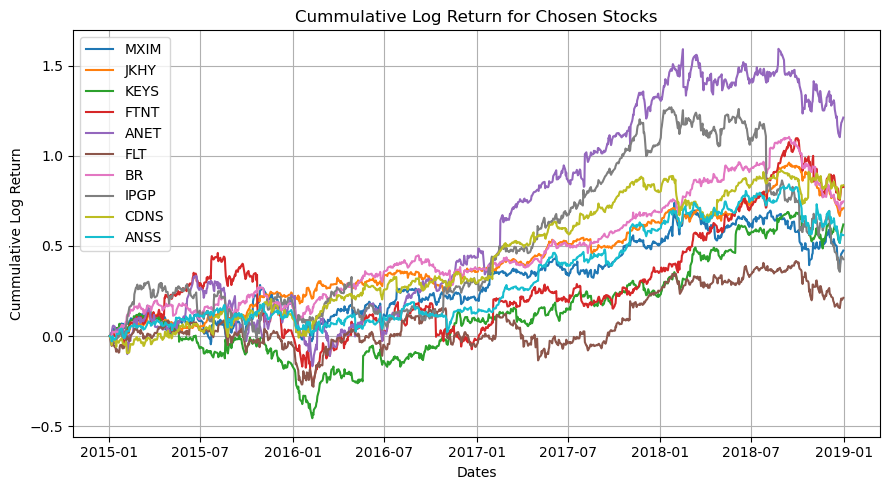

In [81]:
portfolio_selection = snp_info.sort_values('Date first added[3][4]', ascending=False)
portfolio_selection = portfolio_selection.set_index('Symbol')

portfolio_selection = portfolio_selection.loc[portfolio_selection['GICS Sector']=='Information Technology']

portfolio_selection = portfolio_selection[:10]

display(portfolio_selection)

stocks = portfolio_selection.index

returns = np.log(all_stocks[stocks]).diff(1).fillna(0.0) 

plt.figure(dpi=100, figsize=(9,5))
plt.plot(returns.cumsum())
plt.ylabel('Cummulative Log Return')
plt.xlabel('Dates')

plt.title('Cummulative Log Return for Chosen Stocks')
plt.grid(True)
plt.legend(stocks, loc='upper left')
plt.tight_layout()
plt.show()

I thought about choosing a portfolio rule that gives me back a good overall return. Therefore my thoughts were to choose the 10 assets of the companies with the newest date of addition to the index in the area of information technology, since IT is a sector that performed well overall in the last couple of years and I expect from newer companies to be more innovative and have more potential to grow than older companies. And the intuition we get from the graph is that this portfolio indeed performed pretty well also in comparison to the other stocks.

### 5.2

In [82]:
import networkx as nx

Bellow we see the heat map of our correlation matrix. The correlation of the stocks shows some differences, but there are no negatively correlated stocks nor uncorrelated stocks, all stocks are correlated to some degree. All stock correlation values are in the range of 0.28 to 0.57. We would expect such a correlation, since we choose stocks only in the IT sector and this tend to follow same trends.

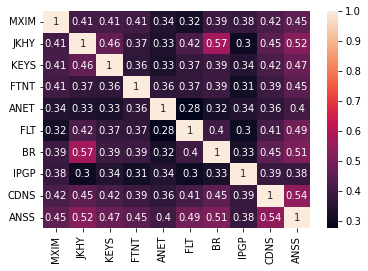

In [83]:
corr = returns.corr()
sn.heatmap(corr, annot=True)
plt.show()

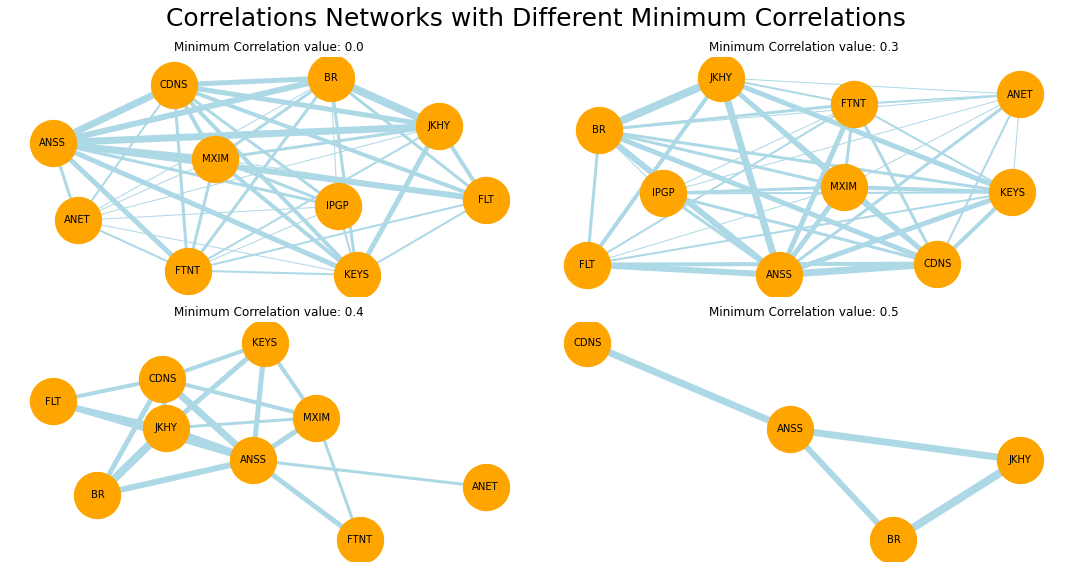

In [84]:
# Transform it in a links data frame (3 columns only):
links = corr.stack().reset_index()
links.columns = ['var1', 'var2', 'value']
values = [0.0, 0.3, 0.4, 0.5]
 
fig, ax = plt.subplots(2,2)
fig.set_size_inches(15,8)
fig.suptitle('Correlations Networks with Different Minimum Correlations', fontsize= 25)
    
for i, value in enumerate(values): 
    if i > 1:
        j=1
    else:
        j=0
        
    # Keep only correlation over a threshold and remove self correlation (cor(A,A)=1)
    links_filtered=links.loc[ (links['value'] > value) & (links['var1'] != links['var2']) ]
 
    # Build your graph
    G = nx.from_pandas_edgelist(links_filtered, 'var1', 'var2', edge_attr='value')
    edges = G.edges()
    min_val = min(links['value'])
    weights = [int(((G[u][v]['value']-min_val)*30)) for u,v in edges]
    ax[j][i%2].set_title('Minimum Correlation value: '+ str(value))
    
    # Plot the network:
    nx.draw(G, ax = ax[j][i%2], with_labels=True, node_color='orange', edge_color='lightblue', width=weights, linewidths=30, font_size=10)
    fig.tight_layout()

Here we see the graphs of the correlation values for different thresholds of correlation. On the upper left we see the graph with all the stocks and all correlations. On the bottom right only the ones that are correlated with a value of more than 0.5. In addition the edges are also showing the correlation: the thicker the edge, the bigger the correlation.

### 5.3 

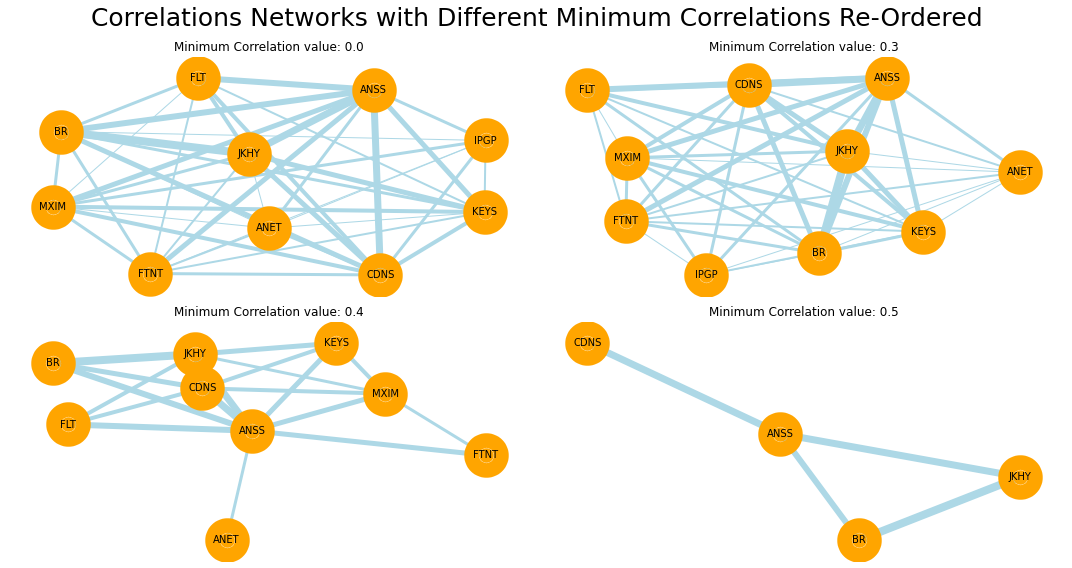

In [85]:
# Transform it in a links data frame (3 columns only):
links = corr.stack().reset_index()
links.columns = ['var1', 'var2', 'value']
values = [0.0, 0.3, 0.4, 0.5]
 
fig, ax = plt.subplots(2,2)
fig.set_size_inches(15,8)
fig.suptitle('Correlations Networks with Different Minimum Correlations Re-Ordered', fontsize= 25)
    
for i, value in enumerate(values): 
    if i > 1:
        j=1
    else:
        j=0
        
    # Keep only correlation over a threshold and remove self correlation (cor(A,A)=1)
    links_filtered=links.loc[ (links['value'] > value) & (links['var1'] != links['var2']) ]
    links_filtered=links_filtered.sample(frac=1)
    # Build your graph
    G = nx.from_pandas_edgelist(links_filtered, 'var1', 'var2', edge_attr='value')
    edges = G.edges()
    min_val = min(links['value'])
    weights = [int(((G[u][v]['value']-min_val)*30)) for u,v in edges]
    ax[j][i%2].set_title('Minimum Correlation value: '+ str(value))
    
    # Plot the network:
    nx.draw(G, ax = ax[j][i%2], with_labels=True, node_color='orange', edge_color='lightblue', node_size=210, width=weights, linewidths=30, font_size=10)
fig.tight_layout()

With the `links_filtered=links_filtered.sample(frac=1)` command we can shuffle our graph vertices but we still get the same result, as expected, since the correlation coefficients remain the same. That's because correlation is independent from data reordering and therefore also if we shuffle the dates of our underlining data, we will still get the same correlation coefficients and edge weights and the same information in our graphs. Just the visual representation would change, since the networkx module does not have a deterministic plotting.

### 5.4

After searching through some papers, dynamic time warping has been proposed multiple times. For reference
$$\textit{ Similarity Measure Selection for Clustering Stock Market Time Series Databases
, Dr.S.Radhimeenakshi, K.Latha}$$

$$ \textit{A Novel Time-Sensitive Composite Similarity Model for Multivariate Time-Series Correlation Analysis,
Mengxia Liang
, Xiaolong Wang , and Shaocong Wu}$$

Dynamic time warping calculates an optimal match between two given time series, with certain restrictions and rules, which can be found here: https://en.wikipedia.org/wiki/Dynamic_time_warping
For us it's important to note, that we also work with different time series and since different stocks may have warying time, dynamic time warping offers a good metric.

In [86]:
from fastdtw import fastdtw
from scipy.spatial.distance import euclidean

In [87]:
similarity_mat = corr

# Go through tickers
for t_idx in returns.columns:
    for t_col in returns.columns:
        distance, path = fastdtw(returns[t_idx], returns[t_col], dist=euclidean)
        similarity_mat[t_idx][t_col] = distance    

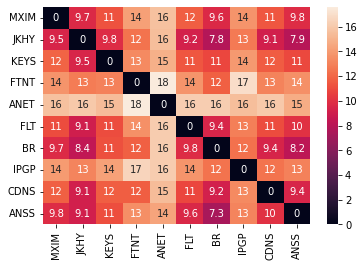

In [88]:
sn.heatmap(similarity_mat, annot=True)
plt.show()

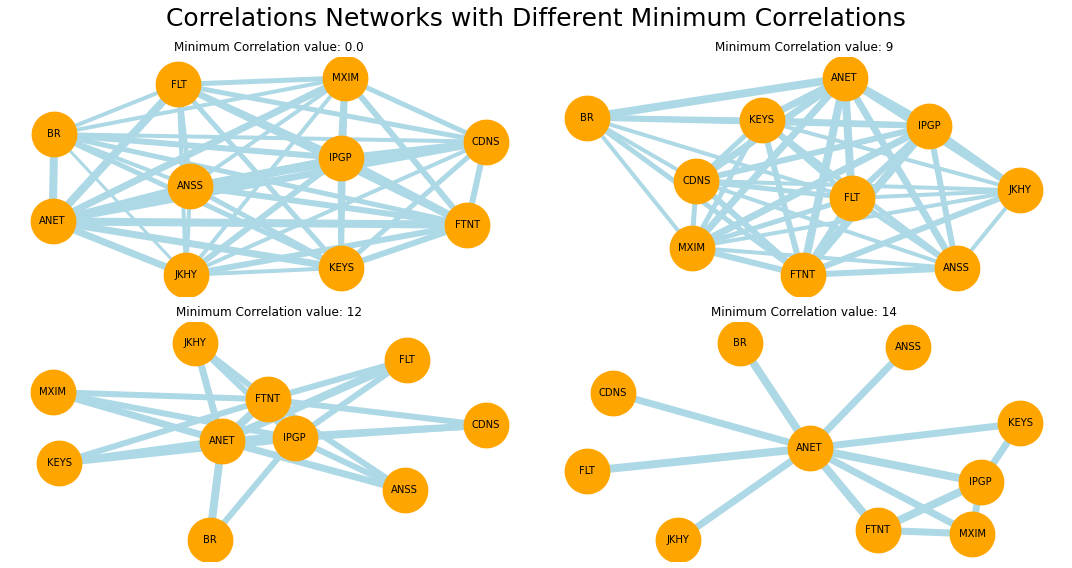

In [89]:
# Transform it in a links data frame (3 columns only):
links = similarity_mat.stack().reset_index()
links.columns = ['var1', 'var2', 'value']
values = [0.0, 9, 12, 14]
 
fig, ax = plt.subplots(2,2)
fig.set_size_inches(15,8)
fig.suptitle('Correlations Networks with Different Minimum Correlations', fontsize= 25)
    
for i, value in enumerate(values): 
    if i > 1:
        j=1
    else:
        j=0
        
    # Keep only correlation over a threshold and remove self correlation (cor(A,A)=1)
    links_filtered=links.loc[ (links['value'] > value) & (links['var1'] != links['var2']) ]
    links_filtered=links_filtered.sample(frac=1)
    # Build your graph
    G = nx.from_pandas_edgelist(links_filtered, 'var1', 'var2', edge_attr='value')
    edges = G.edges()
    min_val = min(links['value'])
    weights = [int(((G[u][v]['value']-min_val))*0.5) for u,v in edges]
    ax[j][i%2].set_title('Minimum Correlation value: '+ str(value))
    
    # Plot the network:
    nx.draw(G, ax = ax[j][i%2], with_labels=True, node_color='orange', edge_color='lightblue', node_size=250, width=weights, linewidths=30, font_size=10)
    fig.tight_layout()

Now we will shuffle the series and plot the graphs again.

In [90]:
shuffled_returns = returns.sample(frac=1,axis=0)

In [91]:
for t_idx in shuffled_returns.columns:
    for t_col in shuffled_returns.columns:
        distance, path = fastdtw(shuffled_returns[t_idx], shuffled_returns[t_col], dist=euclidean)
        similarity_mat[t_idx][t_col] = distance  

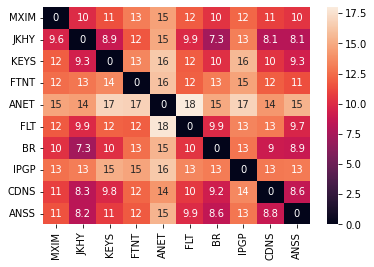

In [92]:
sn.heatmap(similarity_mat, annot=True)
plt.show()

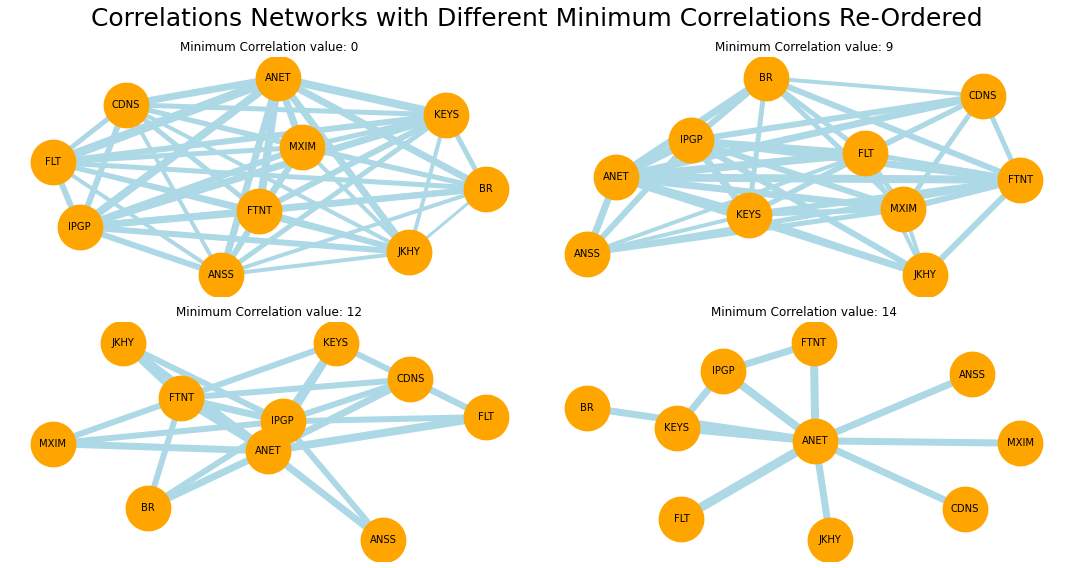

In [93]:
# Transform it in a links data frame (3 columns only):
links = similarity_mat.stack().reset_index()
links.columns = ['var1', 'var2', 'value']
values = [0, 9, 12, 14]

fig, ax = plt.subplots(2,2)
fig.set_size_inches(15,8)
fig.suptitle('Correlations Networks with Different Minimum Correlations Re-Ordered', fontsize= 25)
    
for i, value in enumerate(values): 
    if i > 1:
        j=1
    else:
        j=0
        
    # Keep only correlation over a threshold and remove self correlation (cor(A,A)=1)
    links_filtered=links.loc[ (links['value'] > value) & (links['var1'] != links['var2']) ]
    links_filtered=links_filtered.sample(frac=1)
    # Build your graph
    G = nx.from_pandas_edgelist(links_filtered, 'var1', 'var2', edge_attr='value')
    edges = G.edges()
    min_val = min(links['value'])
    weights = [int(((G[u][v]['value']-min_val))*0.5) for u,v in edges]
    ax[j][i%2].set_title('Minimum Correlation value: '+ str(value))
    
    # Plot the network:
    nx.draw(G, ax = ax[j][i%2], with_labels=True, node_color='orange', edge_color='lightblue', node_size=250, width=weights, linewidths=30, font_size=10)
    fig.tight_layout()

This time, in contrary to the covariance metric, we get different results through time series shuffling. This is the case since our new metric is time dependent. 
We see this when we compare the heatmap graph or if we closely examine the network graph. As an example, the CDNS stock has a higher dynamic time wrapping simillarity to ANET then to KEYS after shuffling. Before CDNS and KEYS had a higher simillarity.

### 5.5

In [94]:
portfolio_selection = snp_info.sort_values('Date first added[3][4]', ascending=False)
portfolio_selection = portfolio_selection.set_index('Symbol')

portfolio_selection = portfolio_selection.loc[portfolio_selection['GICS Sector']=='Information Technology']

portfolio_selection = portfolio_selection[:10]

stocks = portfolio_selection.index

returns = all_stocks[stocks].dropna() 

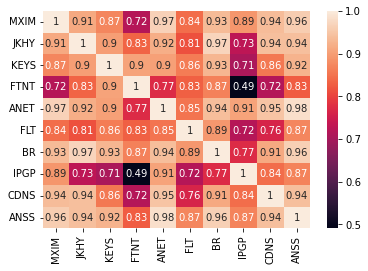

In [95]:
corr = returns.corr()
sn.heatmap(corr, annot=True)
plt.show()

Already in section one we have figured out that the raw prices are non stationary and can thus have disadvantages in comparison to the according log returns. Since the stock trend will influence the correlation the most considering the raw data, the correlation values will be higher than the ones of the log returns. That follows directly from the non stationarity of the data and the underlying trends that are contained in the raw data. 
We can also confirm that by looking at the correlation matrix, which has much higher correlation values than seen before. Therefore out network would be much stronger connected thatn with considering only the covariance matrix of the log returns. 

With using the dynamic time warping metric with the raw data we can expect it to behave similary. Since we still got the mainly upward trend in our data, this trend will be the main factor in distinguishing the distance of certain stocks in this metric and will thus not be as informative as the log return.

In [96]:
returns = all_stocks[stocks].dropna() 
for t_idx in returns.columns:
    for t_col in returns.columns:
        distance, path = fastdtw(returns[t_idx], returns[t_col], dist=euclidean)
        similarity_mat[t_idx][t_col] = distance  

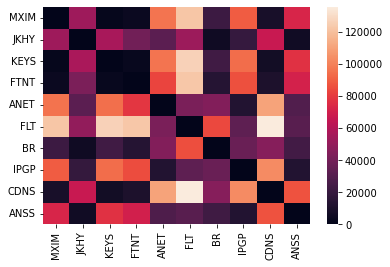

In [97]:
sn.heatmap(similarity_mat)
plt.show()